# Homework Principal Components Analysis

## Computational Linear Algebra For Large Scale Problems, Politecnico Di Torino

### Elisa Salvadori 302630

The aim of this project is to use the Principal Component Analysis (PCA) to reduce
the dimensionality of a preprocessed version of a dataset extracted from bikez.com on April 30th 2022 and then to identify meaningful clusters of motorcycles using the k-Means algorithm. 

In particular, the data file consists of 38472 rows and 27 columns, it contains missing values and both numeric and categorical data.

In [1]:
#Importing useful python packages 

# %matplotlib widget
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.lines import Line2D
import yaml
from IPython.display import display 
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

pd.options.display.max_rows = 9999
pd.options.display.max_columns = 9999

from sklearn.model_selection import ParameterGrid

## Preparation (Setting the Random State)

In [2]:
#Initializing the random state variable rs so that the results could be replicated

rs = 302630
np.random.seed(rs)

## Exercise 1 (Loading and Preparing the Data)

In this section the data is loaded and stored in a dataframe, only a fraction (based on the year) of the original dataset will be used for the project.

The attributes are divided between labels (Brand, Model, Year, Category, Rating) and features (the other ones) and then two features between Front brakes, Front tire, Front suspension, Rear brakes, Rear tire, Rear suspension are chosen randomly to be discarded.

In [3]:
#Loading the dataset and storing it in the variable df_tot (as a dataframe)

my_path = "Data/cla4lsp22_bikez_curated.csv" #Path to the cla4lsp22_bikez_curated.csv file

df_tot = pd.read_csv(my_path)

#Selecting a random integer r among 0, 1, 2 
#and creating a sub-DFs workdf from df_tot such that it contains only data corresponding to years with reminder r,
#if divided by 3

r = np.random.randint(0,3)
workdf = df_tot[df_tot.Year % 3 == r]
workdf.reset_index(inplace = True, drop = True)

#Splitting the columns between labels and features
#and removing randomly from workdf two columns selected among the features: 
#Front/Rear breaks, Front/Rear tire, Front/Rear suspension.

labels = ["Brand", "Model", "Year", "Category", "Rating"]
features = workdf.columns.drop(labels).tolist()

target_columns =  ["Front brakes", "Front tire", "Front suspension", "Rear brakes", "Rear tire", "Rear suspension"]
index_dropped_columns = np.random.choice(np.arange(6), size = 2, replace = False) #Getting two random integers without replacement between 0 and 5

print("**********")
print("Removing randomly from workdf two columns selected among the features: Front/Rear breaks, Front/Rear tire, Front/Rear suspension:")
for i in index_dropped_columns: #Removing the 2 selected features 
    features.remove(target_columns[i])
    print("-" + str(target_columns[i]) + " has been removed.")
print()
workdf = workdf[labels + features] #Dataset workdf without the 2 selected columns

print("**********Dataset extracted from  cla4lsp22_bikez_curated.csv**********")
display(workdf)
print()
print("**********Info of the dataset extracted from cla4lsp22_bikez_curated.csv**********")
workdf.info()
print()

**********
Removing randomly from workdf two columns selected among the features: Front/Rear breaks, Front/Rear tire, Front/Rear suspension:
-Front brakes has been removed.
-Rear brakes has been removed.

**********Dataset extracted from  cla4lsp22_bikez_curated.csv**********


,Brand,Model,Year,Category,Rating,Displacement (ccm),Power (hp),Torque (Nm),Engine cylinder,Engine stroke,Gearbox,Bore (mm),Stroke (mm),Fuel capacity (lts),Fuel control,Cooling system,Transmission type,Dry weight (kg),Wheelbase (mm),Seat height (mm),Fuel system,Front tire,Rear tire,Front suspension,Rear suspension
0,acabion,da vinci 650-vi,2011,Prototype / concept model,3.2,NaN,804.0,NaN,Electric,Electric,Not Given/Unknown,NaN,NaN,NaN,Not Given/Unknown,Liquid,Chain,420.0,NaN,NaN,not given/unknown,other,other,not given/unknown,not given/unknown
1,acabion,gtbo 600 daytona-vi,2011,Prototype / concept model,3.5,NaN,536.0,NaN,Electric,Electric,Not Given/Unknown,NaN,NaN,NaN,Not Given/Unknown,Liquid,Not Given/Unknown,420.0,NaN,NaN,not given/unknown,other,other,not given/unknown,not given/unknown
2,access,shade sport 650 eps,2020,ATV,NaN,608.0,45.6,NaN,Single cylinder,four-stroke,Automatic,NaN,NaN,21.0,Overhead Cams (OHC),Liquid,Chain,342.0,NaN,NaN,not given/unknown,other,other,not given/unknown,not given/unknown
3,access,shade sport 850 lv,2020,ATV,NaN,781.0,57.7,NaN,Single cylinder,four-stroke,Automatic,NaN,NaN,21.0,Overhead Cams (OHC),Liquid,Chain,342.0,NaN,NaN,not given/unknown,25/8-12,25/10-12,other,other
4,access,shade sport 850 touring,2020,ATV,NaN,781.0,57.7,NaN,Single cylinder,four-stroke,Automatic,NaN,NaN,21.0,Overhead Cams (OHC),Liquid,Chain,358.0,NaN,NaN,not given/unknown,other,other,other,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12261,zündapp,rs 50 roller super,1969,Scooter,NaN,49.0,NaN,NaN,Single cylinder,two-stroke,Not Given/Unknown,39.0,42.0,NaN,Not Given/Unknown,Air,Not Given/Unknown,NaN,NaN,NaN,carburettor. other,other,other,not given/unknown,not given/unknown
12262,zündapp,z 2 g,1924,Sport,NaN,211.0,2.8,NaN,Single cylinder,two-stroke,2-speed,62.0,70.0,6.0,Not Given/Unknown,Air,Belt,73.0,NaN,NaN,carburettor,other,other,other,other
12263,zündapp,z 22,1921,Sport,NaN,211.0,2.3,NaN,Single cylinder,two-stroke,2-speed,62.0,70.0,6.0,Not Given/Unknown,Air,Belt,58.0,NaN,NaN,carburettor,other,other,other,other
12264,zündapp,z 22,1924,Sport,NaN,211.0,2.3,NaN,Single cylinder,two-stroke,Not Given/Unknown,62.0,70.0,6.0,Not Given/Unknown,Air,Belt,NaN,NaN,NaN,carburettor,other,other,other,other



**********Info of the dataset extracted from cla4lsp22_bikez_curated.csv**********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                12266 non-null  object 
 1   Model                12258 non-null  object 
 2   Year                 12266 non-null  int64  
 3   Category             12266 non-null  object 
 4   Rating               7227 non-null   float64
 5   Displacement (ccm)   11903 non-null  float64
 6   Power (hp)           8266 non-null   float64
 7   Torque (Nm)          5010 non-null   float64
 8   Engine cylinder      12266 non-null  object 
 9   Engine stroke        12266 non-null  object 
 10  Gearbox              12266 non-null  object 
 11  Bore (mm)            9036 non-null   float64
 12  Stroke (mm)          9036 non-null   float64
 13  Fuel capacity (lts)  10131 non-null  float64
 14  Fu

In [4]:
#Cleaning the dataset workdf from missing values in the features columns

workdf_copy = workdf.copy() #Making a copy of workdf for the Appendix

print("**********Statistics of the numeric features**********")
display(workdf[features].describe()) #Describing some statistics for the numeric features
print()

missing_numeric = workdf[features].isnull().sum(axis = 1) #Series of the number of missing numeric features for every row
numeric_features = workdf[features].select_dtypes(include = ['number']).columns #Only numeric features
missing_numeric_max = missing_numeric[missing_numeric 
                                      == len(list(numeric_features))] #Only contains rows which miss all the numeric features 

print("**********")
print("The percentage of lines for which all the numeric features are missing is:" 
      +  str(round(missing_numeric_max.count()/workdf.shape[0]*100,2)) + "%.")
missing_numeric_not_zero = missing_numeric[missing_numeric > 0]
print("The percentage of lines for which one or more numeric features are missing is:" 
      + str(round(missing_numeric_not_zero.count()/workdf.shape[0]*100,2)) + "%.")

**********Statistics of the numeric features**********


,Displacement (ccm),Power (hp),Torque (Nm),Bore (mm),Stroke (mm),Fuel capacity (lts),Dry weight (kg),Wheelbase (mm),Seat height (mm)
count,11903.000000,8266.000000,5010.000000,9036.000000,9036.000000,10131.000000,7187.000000,7980.000000,7511.000000
mean,540.730984,48.986717,64.106188,72.517309,64.625066,13.273138,161.933032,1423.916917,788.905605
std,545.884244,52.253851,64.093824,18.556811,17.853180,5.995462,84.045360,169.006511,85.220574
min,25.000000,0.300000,1.600000,1.000000,0.000000,0.500000,15.500000,770.000000,385.000000
25%,125.000000,11.500000,12.800000,57.000000,53.400000,8.330000,104.000000,1322.000000,745.000000
50%,349.700000,27.000000,56.300000,72.500000,61.200000,13.500000,142.000000,1422.500000,790.000000
75%,798.000000,73.800000,100.000000,88.000000,72.000000,17.410000,197.000000,1500.000000,830.000000
max,8200.000000,804.000000,710.000000,176.000000,156.000000,64.340000,780.000000,3327.000000,1057.000000



**********
The percentage of lines for which all the numeric features are missing is:0.07%.
The percentage of lines for which one or more numeric features are missing is:85.92%.


The are missing values both in the numeric and in the categorical features:
- Approximately 85% of the records miss at least 1 numeric attribute, so removing them could lead to a huge loss of information. But only a very small number of records miss all the numeric features, so they could be removed. The NaN are replaced with the column median, instead of the mean, because of the presence of skewed distributions and because it is less sensitive to outliers.
- For what it concerns the categorical features the values "Not Given/Unknown", "not given/unknown" are treated as another category under the name "Unknown".

(See the appendix for the boxplots of the numeric features and some information regarding the categorical ones.)

In [5]:
#Removing only the lines for which all the numeric features are missing 
workdf.drop(labels = missing_numeric_max.index, inplace = True)
workdf.reset_index(inplace = True, drop = True)

#Replacing the NaN values for a column with its median
workdf.fillna(value = workdf[features].select_dtypes(include = ['number']).median(), inplace = True)

#Replacing Not Given/Unknown and not Guven/unknown for the categorical features with only Unknown 
workdf.replace('Not Given/Unknown','Unknown', inplace = True)
workdf.replace('not given/unknown','Unknown', inplace = True)

## Exercise 2 (Encoding of Categorical Data)

The categorical features are encoded using One-hot encoding.
Some categorical features in the dataset consist in lists of characteristics represented by a string and separated by the characters '. ', in the encoded dataset these lists are splitted in unique values only (which represents a level of the categorical feature) and avery rows have 1 when it has the characteristic considered and 0 otherwise.

The encoded dataset consisting only in the dataset without labels is stored in a dataframe called Xworkdf.

In [6]:
categorical_features = workdf[features].select_dtypes(exclude = ['number']).columns #Getting only the categorical features


for feature in categorical_features: #unique_values is the array of the unique values of the feature considered (also the lists)
    unique_values = workdf[feature].unique()
    single_unique_values = []

    #Single unique values is a set constructed by only unique values od unique_values 

    for value in unique_values: 
        single_unique_values.extend(value.split('. '))
        
    single_unique_values = list(dict.fromkeys(single_unique_values))  # Removing duplicates
    
    for value in single_unique_values:
        #For every value which represents a new column it computes a new series with 1 if it is present
        #and 0 otherwise
        new_value = feature + "-" + value #The name of the new columns is represented by the original feature - unique value
        new_col = workdf[feature].apply(lambda x: 1 if value in x.split('. ') else 0)
        new_col.name = new_value
        workdf = workdf.join(new_col) #Joining the new column at the dataset
        
workdf.drop(columns = categorical_features, inplace = True) #Dropping the original categorical features from the dataset
Xworkdf = workdf.drop(columns = labels) #Creating a new dataset with the features only (properly encoded)

In [7]:
display(Xworkdf)

,Displacement (ccm),Power (hp),Torque (Nm),Bore (mm),Stroke (mm),Fuel capacity (lts),Dry weight (kg),Wheelbase (mm),Seat height (mm),Engine cylinder-Electric,Engine cylinder-Single cylinder,Engine cylinder-Twin,Engine cylinder-V2,Engine cylinder-V4,Engine cylinder-Diesel,Engine cylinder-Square four cylinder,Engine cylinder-V8,Engine cylinder-In-line four,Engine cylinder-In-line six,Engine cylinder-In-line three,Engine cylinder-Two cylinder boxer,Engine cylinder-Four cylinder boxer,Engine cylinder-V6,Engine cylinder-Single disc Wankel,Engine cylinder-Six cylinder boxer,Engine cylinder-V3,Engine cylinder-Radial,Engine cylinder-Gas turbine,Engine cylinder-Dual disc Wankel,Engine stroke-Electric,Engine stroke- four-stroke,Engine stroke- two-stroke,Engine stroke-Diesel,Engine stroke-Square four cylinder,Engine stroke-Single disc Wankel,Engine stroke-Radial,Engine stroke-Gas turbine,Engine stroke-Dual disc Wankel,Gearbox-Unknown,Gearbox-Automatic,Gearbox-1-speed,Gearbox-3-speed,Gearbox-4-speed,Gearbox-5-speed,Gearbox-6-speed,Gearbox-8-speed,Gearbox-2-speed,Gearbox-7-speed,Gearbox-4-speed with reverse,Gearbox-2-speed automatic,Gearbox-5-speed with reverse,Gearbox-6-speed with reverse,Gearbox-10-speed,Gearbox-100-speed,Fuel control-Unknown,Fuel control-Overhead Cams (OHC),Fuel control-Single Overhead Cams (SOHC),Fuel control-Overhead Valves (OHV),Fuel control-Double Overhead Cams/Twin Cam (DOHC),Fuel control-Membrane & variable discharge openings,Fuel control-Membrane,Fuel control-Rotary valves,Fuel control-Port control,Fuel control-Desmodromic valve control,Fuel control-Sidevalves,Fuel control-Standing valves,Fuel control-Pushrods,Fuel control-Membrane & power valve,Fuel control-Rotary valves & variable discharge openings,Cooling system-Liquid,Cooling system-Unknown,Cooling system-Air,Cooling system-Oil & air,Transmission type-Chain,Transmission type-Unknown,Transmission type-Belt,Transmission type-Shaft drive,Fuel system-Unknown,Fuel system-carburettor,Fuel system-injection,Fuel system-other,Fuel system-efi,Front tire-other,Front tire-25/8-12,Front tire-120/70-12,Front tire-100/80-17,Front tire-90/90-21,Front tire-110/70-17,Front tire-100/90-18,Front tire-120/70-17,Front tire-80/100-21,Front tire-100/90-19,Rear tire-other,Rear tire-25/10-12,Rear tire-130/70-12,Rear tire-120/70-12,Rear tire-130/60-13,Rear tire-130/70-17,Front suspension-Unknown,Front suspension-other,Front suspension-telescopic fork,Front suspension-telescopic,Front suspension-telescopic forks,"Front suspension-telescopic, coil spring, oil damped",Rear suspension-Unknown,Rear suspension-other,Rear suspension-monoshock,Rear suspension-swing arm,Rear suspension-twin shocks,Rear suspension-dual shocks,Rear suspension-single shock,"Rear suspension-link type, coil spring, oil damped"
0,349.7,804.0,56.3,72.5,61.2,13.5,420.0,1422.5,790.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,349.7,536.0,56.3,72.5,61.2,13.5,420.0,1422.5,790.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,608.0,45.6,56.3,72.5,61.2,21.0,342.0,1422.5,790.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,781.0,57.7,56.3,72.5,61.2,21.0,342.0,1422.5,790.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,781.0,57.7,56.3,72.5,61.2,21.0,358.0,1422.5,790.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0

## Exercise 3 (Preprocessing and PCA)

The numeric features of the dataset have different units of measures and different orders of magnitude, which can lead to have a very small set of features that "eats" all the information when computing the variance of the data. So a rescaling of the data is computed in order to get rid of this behaviour, in particular a StandardScaler and a MinMaxScaler are used.

In [8]:
#Preproccesing of the data, transformation with StandardScaler and MinMaxScaler

Xworkdf_std = pd.DataFrame(StandardScaler().fit_transform(Xworkdf), 
                           columns = Xworkdf.columns) #Dataframe created with Standardascaler

Xworkdf_mm = pd.DataFrame(MinMaxScaler().fit_transform(Xworkdf), columns = Xworkdf.columns) #Dataframe created with MinMaxScaler


In [9]:
#Computing the variance of the original working dataset (after the preprocessing: cleaning and encoding), and the variance of 
#the dataset transformed with StandardScaler and the one transformed with MinMaxScaler

Xworkdf_var = Xworkdf.var() #Varinace Original
Xworkdf_std_var = Xworkdf_std.var() #Variance with StandardScaler
Xworkdf_mm_var = Xworkdf_mm.var() #Variance with MinMaxScaler

#Only setting the names of the series
Xworkdf_var.name = "Variance of Xworkdf"
Xworkdf_std_var.name = "Variance of Xworkdf with StandardScaler"
Xworkdf_mm_var.name = "Variance of Xworkdf with MinMaxScaler"

#Dataframe with all the variance
variance_dataframe = pd.concat([Xworkdf_var, Xworkdf_mm_var, Xworkdf_std_var], axis = 1)
print("**********Variance of the three datasets considering only the numeric features**********" )
display(variance_dataframe.iloc[0:9])
print()

**********Variance of the three datasets considering only the numeric features**********


,Variance of Xworkdf,Variance of Xworkdf with MinMaxScaler,Variance of Xworkdf with StandardScaler
Displacement (ccm),290385.256565,0.004345,1.000082
Power (hp),1947.346165,0.003015,1.000082
Torque (Nm),1693.528494,0.003375,1.000082
Bore (mm),253.834552,0.008288,1.000082
Stroke (mm),237.223017,0.009748,1.000082
Fuel capacity (lts),29.715188,0.007291,1.000082
Dry weight (kg),4237.620488,0.007250,1.000082
Wheelbase (mm),18594.384370,0.002844,1.000082
Seat height (mm),4450.126933,0.009854,1.000082


In the table above, it could be easily seen that, without a rescaling of the dataset, there are different orders of magnitude (the "Displacement" feature has a very large variance compared to others).

With the Min-Max Scaler all the features get the same order of magnitude of the variance, but some of them have a greater variance.

With the StandardScaler all the numeric features have unit variance, because the data are rescaled by removing the mean and dividing by the standard deviation.

In [10]:
print("**********Variance of the three datasets considering only the encoded categorical features**********" )
display(variance_dataframe.sort_values(by = "Variance of Xworkdf", ascending = False).iloc[9:].head())
print()

**********Variance of the three datasets considering only the encoded categorical features**********


,Variance of Xworkdf,Variance of Xworkdf with MinMaxScaler,Variance of Xworkdf with StandardScaler
Front suspension-other,0.250020,0.250020,1.000082
Engine cylinder-Single cylinder,0.248058,0.248058,1.000082
Rear suspension-other,0.247948,0.247948,1.000082
Transmission type-Chain,0.247743,0.247743,1.000082
Cooling system-Air,0.246988,0.246988,1.000082


Categorical features where encoded using Hot-hot encoding, so MinMaxscaler has no effect on them. But it also could be seen that some features has a variance epproximately equal to 0.25. 



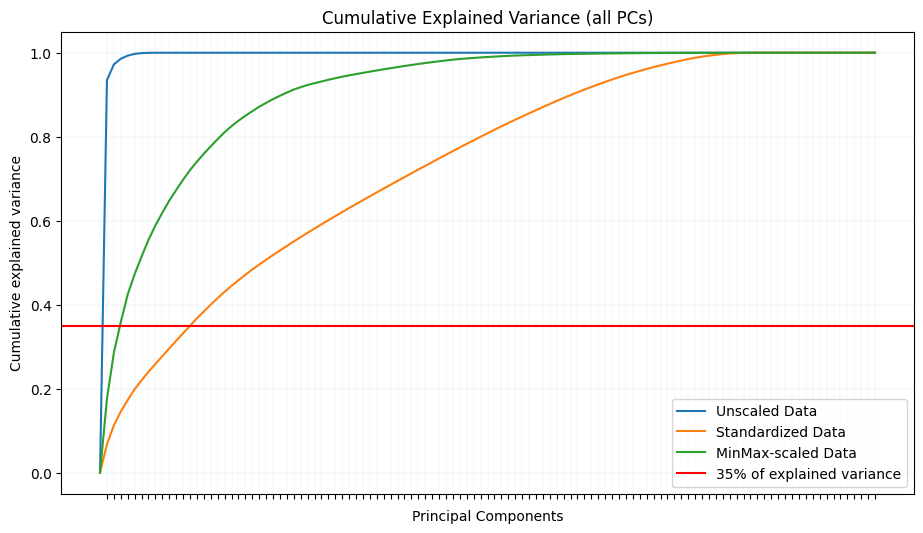

In [11]:
#Apllying the full PCA (without dimensionality reduction)
pca_original = PCA(random_state = rs) 
pca_original.fit(Xworkdf) #PCA unscaled data

pca_std = PCA(random_state = rs)
pca_std.fit(Xworkdf_std) #PCA standardized data

pca_mm = PCA(random_state = rs)
pca_mm.fit(Xworkdf_mm) #PCA MinMax-scaled data

#Making the comulative explained variance plot

plt.figure(figsize = (11, 6))
plt.plot(np.insert(np.cumsum(pca_original.explained_variance_ratio_), 0, 0), label = "Unscaled Data")
plt.plot(np.insert(np.cumsum(pca_std.explained_variance_ratio_), 0, 0), label = "Standardized Data")
plt.plot(np.insert(np.cumsum(pca_mm.explained_variance_ratio_), 0, 0), label = "MinMax-scaled Data")
plt.axhline(y = 0.35, color = 'red', linestyle = '-', 
            label = "35% of explained variance")
plt.legend()
plt.title('Cumulative Explained Variance (all PCs)')
plt.xticks(ticks = np.arange(1, pca_original.n_features_ + 1), labels = [])
plt.xticks(fontsize = 5)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance')
plt.grid(color = 'lightsteelblue', linestyle = '-', linewidth = 0.12)
plt.show()

The graph above shows that when applying the PCA to the original dataset (without scaling), only the first PC explains more than 90% of the variance, and with with 4 PCs a percentage of explained variance that is approximately 100% is reached (due to larger order of magnitude of some features).

When scaling the data more PCs are needed to reach approximately 100% of explained variance.

## Exercise 4 (Dimensionality Reduction and Interpretation of the PCs)

In order to make the data easier to be interpreted the information is summarized with at most m = 5 features with at least 35% of preserved information.

The minimum of PCs is computed as $min(m^*,m)$, where $m^*$ is the minimum number of PCs to get at least 35% of explained variance.

In [12]:
m = 5 #PCs
perc = 0.35 #Percentage of explained variance

#Computing the number of PCs for Xworkdf_std
for variance in np.cumsum(pca_std.explained_variance_ratio_): #Getting the value in the cumulative variance array which is at least 35%
    if variance > perc:
        break
index = int(np.where(np.cumsum(pca_std.explained_variance_ratio_) == variance)[0]) #Getting the index in the array

m_std = min(m, index + 1) #Computing m_star (the number of PCs is index + 1 because of indexing starts from 0)

In [13]:
#Computing the number of PCs for Xworkdf_mm
for variance in np.cumsum(pca_mm.explained_variance_ratio_): #Getting the value in the cumulative variance array which is at least 35%
    if variance > perc:
        break
index = int(np.where(np.cumsum(pca_mm.explained_variance_ratio_) == variance)[0]) #Getting the index in the array

m_mm = min(m, index + 1) #Computing m_star (the number of PCs is index + 1 because of indexing starts from 0)

**********barplots of percentage of explained variance**********


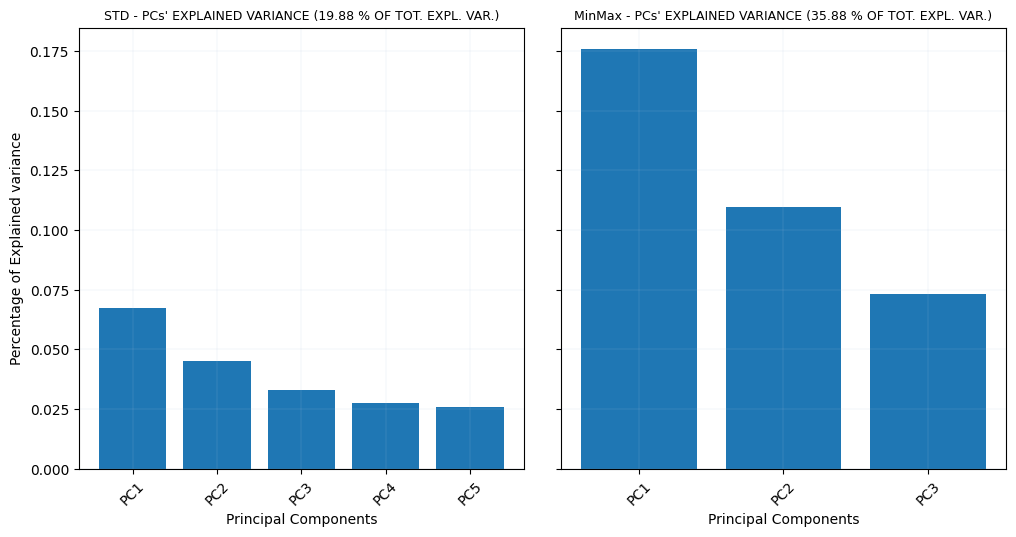

In [14]:
#Initializing and fit PCA for Xworkdf_std and Xworkdf_mm

pca_std = PCA(random_state = rs, n_components = m_std)
pca_std.fit(Xworkdf_std) #PCA Xworkdf_std

pca_mm = PCA(random_state = rs, n_components = m_mm)
pca_mm.fit(Xworkdf_mm) #PCA Xworkdf_mm

#Computing the percentage of tot. expl. variance (rounded to 2 decimals)
round_expl_var_ratio_std = np.round(pca_std.explained_variance_ratio_.sum() * 100, decimals = 2) #Xworkdf_std
round_expl_var_ratio_mm = np.round(pca_mm.explained_variance_ratio_.sum() * 100, decimals = 2) #Xworkdf_mm

#Making the barplots
print("**********barplots of percentage of explained variance**********")
fig, (ax_std, ax_mm) = plt.subplots(1, 2, figsize = (10, 5), sharey = True)
plt.tight_layout()
ax_std.bar(range(1, m_std + 1), pca_std.explained_variance_ratio_)
ax_std.set_title(f"STD - PCs' EXPLAINED VARIANCE ({round_expl_var_ratio_std} % OF TOT. EXPL. VAR.)", fontsize = 9)
ax_std.set_xticks(ticks = np.arange(1, m_std + 1))
ax_std.set_xticklabels([f'PC{i}' for i in range(1, m_std + 1)], rotation = 45)
ax_std.set_xlabel('Principal Components')
ax_std.set_ylabel('Percentage of Explained variance')
ax_std.grid(color = 'lightsteelblue', linestyle = '-', linewidth = 0.12)

ax_mm.bar(range(1, m_mm + 1), pca_mm.explained_variance_ratio_)
ax_mm.set_title(f"MinMax - PCs' EXPLAINED VARIANCE ({round_expl_var_ratio_mm} % OF TOT. EXPL. VAR.)", fontsize = 9)
ax_mm.set_xticks(ticks = np.arange(1, m_mm + 1))
ax_mm.set_xticklabels([f'PC{i}' for i in range(1, m_mm + 1)], rotation = 45)
ax_mm.set_xlabel('Principal Components')
ax_mm.grid(color = 'lightsteelblue', linestyle = '-', linewidth = 0.12)

Now, to better understand the PCs and to give an interpretation to the vectors of the basis, for each PC it is printed the name of the feature with greatest contribute w.r.t to the threshold $\epsilon = \sqrt{\frac{1}{n}}$, where $n$ is the number of features.

********** MinMax Scaled Data **********


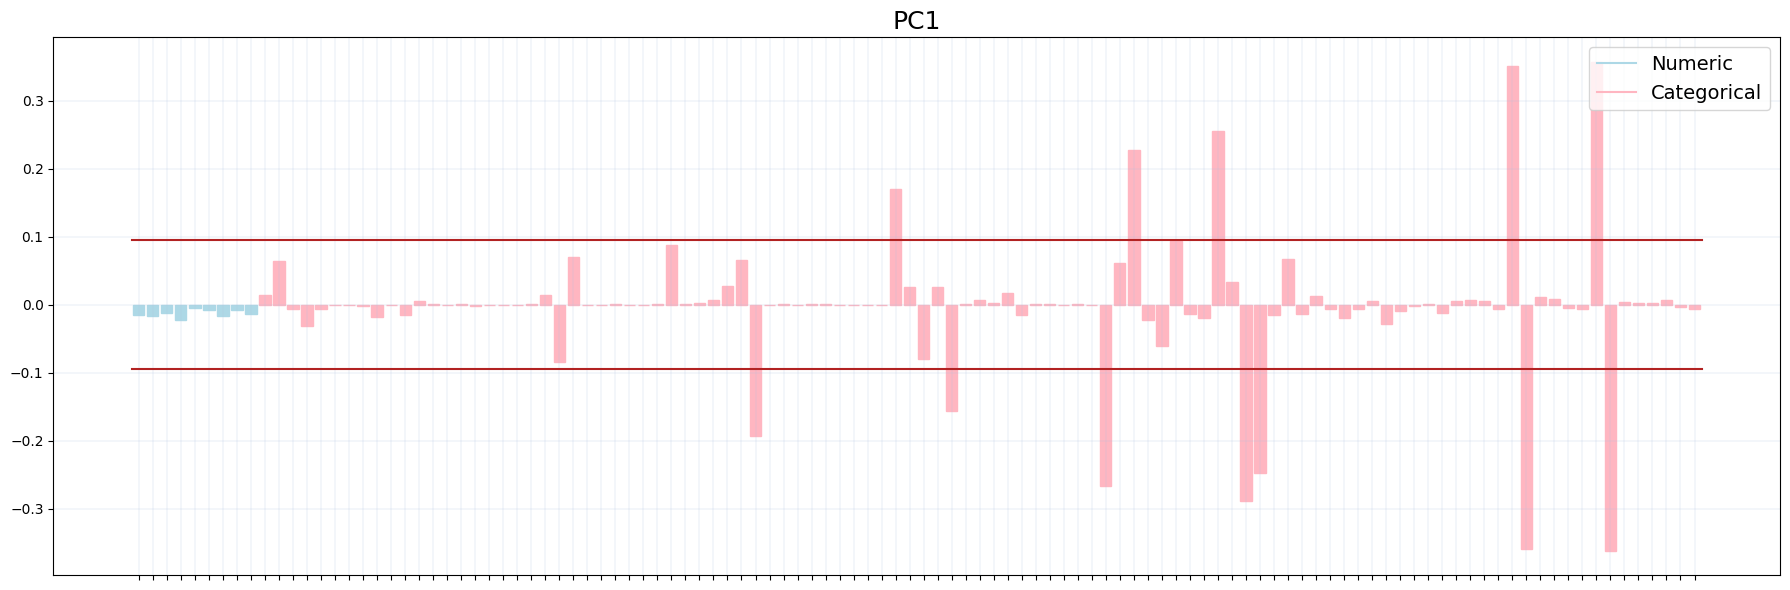


********** PC1 **********
HIGH-VALUED POSITIVE COMPONENTS: ['Fuel control-Unknown', 'Cooling system-Air', 'Fuel system-Unknown', 'Front suspension-Unknown', 'Rear suspension-Unknown']

HIGH-VALUED NEGATIVE COMPONENTS: ['Gearbox-6-speed', 'Fuel control-Double Overhead Cams/Twin Cam (DOHC)', 'Cooling system-Liquid', 'Fuel system-injection', 'Fuel system-other', 'Front suspension-other', 'Rear suspension-other']
**************************



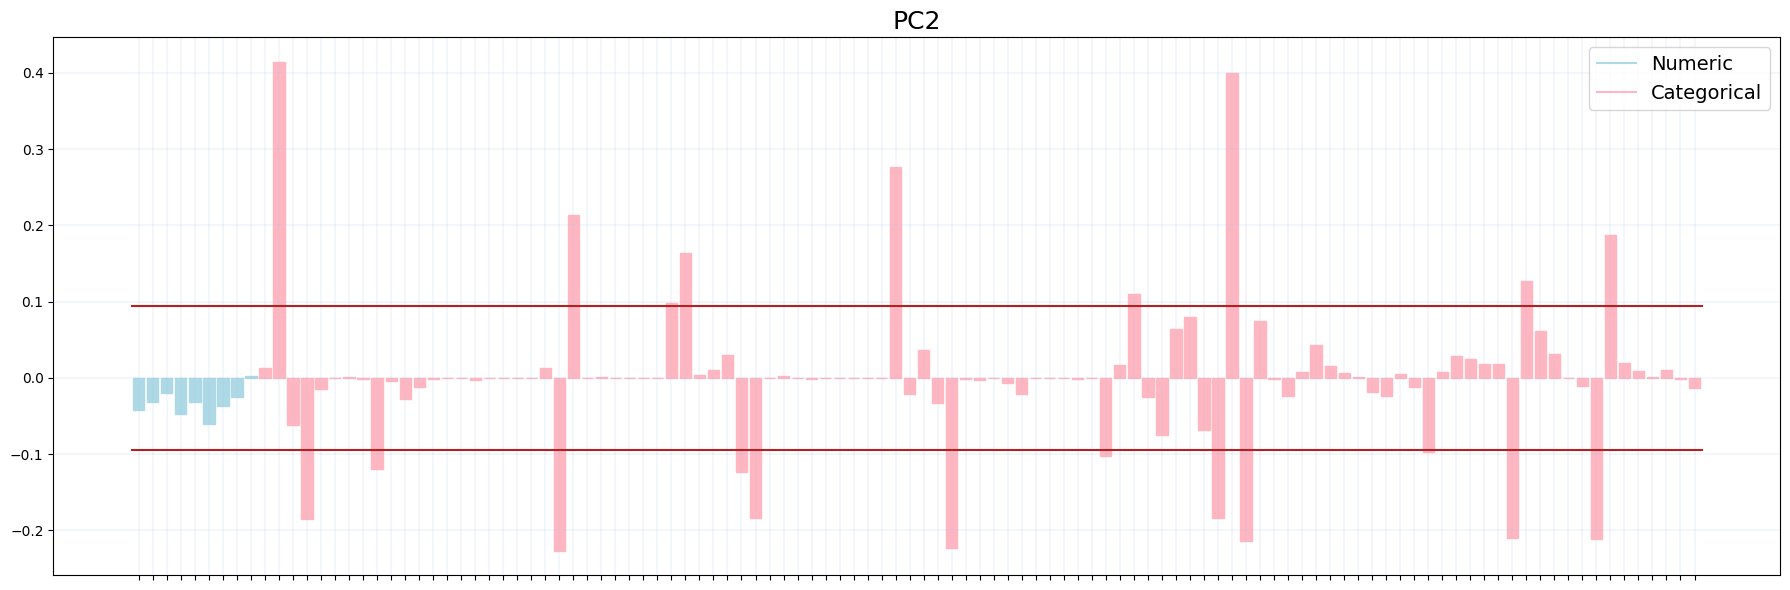


********** PC2 **********
HIGH-VALUED POSITIVE COMPONENTS: ['Engine cylinder-Single cylinder', 'Engine stroke- two-stroke', 'Gearbox-Unknown', 'Gearbox-Automatic', 'Fuel control-Unknown', 'Cooling system-Air', 'Fuel system-carburettor', 'Front suspension-other', 'Rear suspension-other']

HIGH-VALUED NEGATIVE COMPONENTS: ['Engine cylinder-V2', 'Engine cylinder-In-line four', 'Engine stroke- four-stroke', 'Gearbox-5-speed', 'Gearbox-6-speed', 'Fuel control-Double Overhead Cams/Twin Cam (DOHC)', 'Cooling system-Liquid', 'Fuel system-Unknown', 'Fuel system-injection', 'Rear tire-other', 'Front suspension-Unknown', 'Rear suspension-Unknown']
**************************



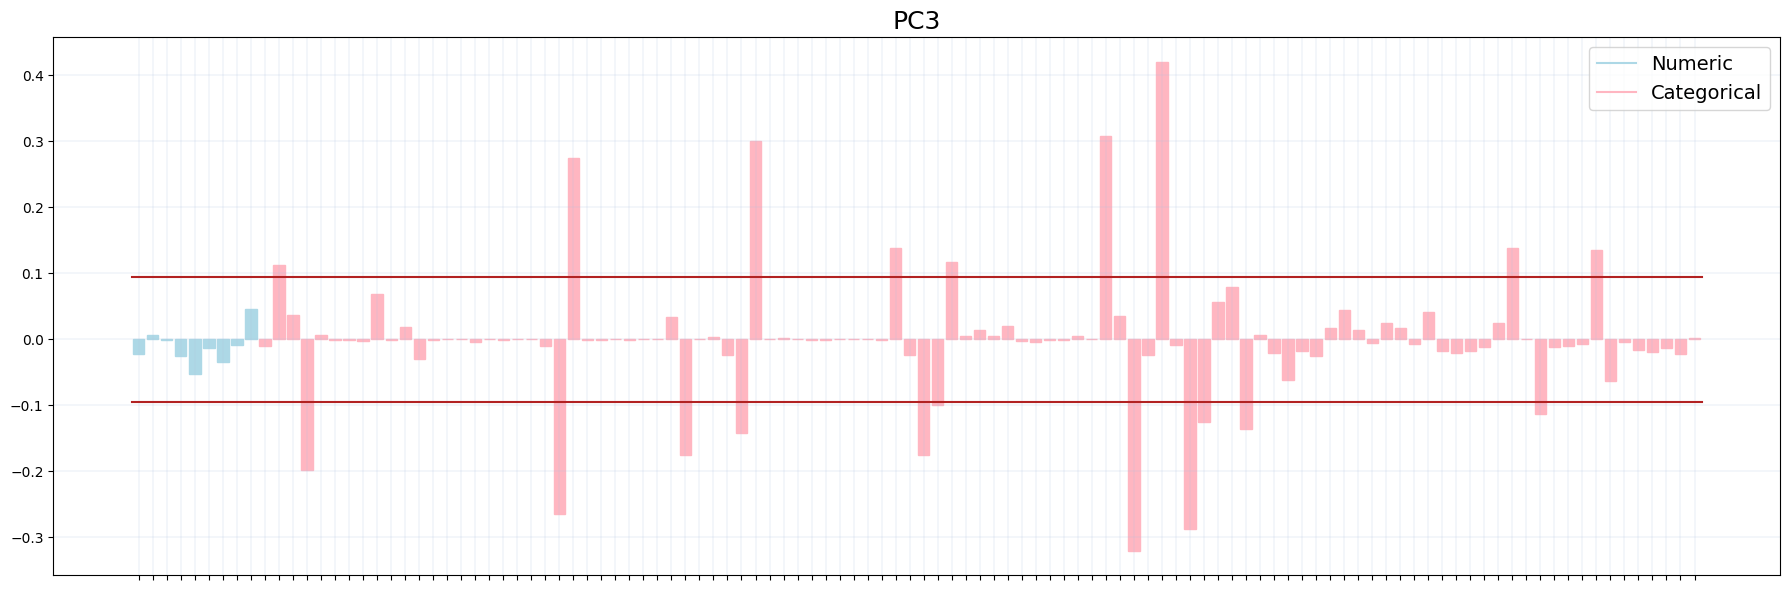


********** PC3 **********
HIGH-VALUED POSITIVE COMPONENTS: ['Engine cylinder-Single cylinder', 'Engine stroke- two-stroke', 'Gearbox-6-speed', 'Fuel control-Unknown', 'Fuel control-Double Overhead Cams/Twin Cam (DOHC)', 'Cooling system-Liquid', 'Transmission type-Chain', 'Front suspension-Unknown', 'Rear suspension-Unknown']

HIGH-VALUED NEGATIVE COMPONENTS: ['Engine cylinder-V2', 'Engine stroke- four-stroke', 'Gearbox-Automatic', 'Gearbox-5-speed', 'Fuel control-Single Overhead Cams (SOHC)', 'Fuel control-Overhead Valves (OHV)', 'Cooling system-Air', 'Transmission type-Belt', 'Transmission type-Shaft drive', 'Fuel system-injection', 'Front suspension-telescopic fork']
**************************



In [15]:
#PCs Xworkdf_mm

col_numeric = Xworkdf_mm.columns[:9]

#Defining epsilon
eps = np.sqrt(1 / pca_mm.n_features_)

#For-cycle to generalize the plot commands
print("********** MinMax Scaled Data **********")
for ii in range(m_mm):
    plt.figure(figsize = (18, 6))
    bars = plt.bar(np.arange(pca_mm.n_features_), pca_mm.components_[ii, :])
    
    #Setting colors: blue bar if it is a numeric feature and red if it is categorical
    for i, bar in enumerate(bars):
        col = Xworkdf_mm.columns[i]
        if col in col_numeric:
            bar.set_color('lightblue')
        else:
            bar.set_color('lightpink')
    
    #Making the legend
    plt.legend(handles = [plt.Line2D([0], [0], color = 'lightblue', label = 'Numeric'),
                        plt.Line2D([0], [0], color = 'lightpink', label = 'Categorical')], loc = 'upper right', fontsize = 14)
    
    # --- red line denoting the threshold [-eps, +eps] -----------------
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [eps, eps], 'firebrick')
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [-eps, -eps], 'firebrick')
    # ------------------------------------------------------------------
    plt.xticks(ticks = np.arange(pca_mm.n_features_), labels = [], rotation = 75)
    plt.title(f'PC{ii + 1}', fontsize = 18)
    plt.rc('xtick', labelsize = 20)
    plt.grid(color = 'lightsteelblue', linestyle = '-', linewidth = 0.2)
    plt.tight_layout()
    plt.show()
    
    #Selecting features with contribute greater than the threshold
    ind_great_pos_PCii = np.argwhere(pca_mm.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_mm.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [Xworkdf_mm.columns[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [Xworkdf_mm.columns[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'********** PC{ii+1} **********')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('**************************')
    print('')

Looking at the barplots and the features printed above: Numercic features have been less involved in this case with the Min-Max Scaler due to the lower variance with respect to categorical features.

PC1: Air (+) Vs Liquid (-) <br>
'Cooling system-Air' is in the higher-value positive components. <br>
While 'Cooling system-Liquid' is in the higher-value negative components.

PC2: "Fuel Consumption and Maintainance" <br>
'Engine cylinder-Single cylinder', 'Engine stroke- two-stroke' and 'Fuel system-carburettor' are in the higher-value positive components. <br>
While 'Engine cylinder-V2', 'Engine stroke- four-stroke', and 'Fuel control-Double Overhead Cams/Twin Cam (DOHC)', 'Fuel system-injection are in the higher-value negative components. <br> In general, a 2-stroke motorcycle with a single-cylinder and a carburettor is likely to consume more fuel than a 4-stroke, V2 motorcycle with fuel injection and an advanced control system such as the Double Overhead Cams/Twin Cam (DOHC). <br> 2-stroke engines has a simpler design than 4-stroke and this semplicity could lead to more frequent mantainance requirements because of they require a mixture of oil and fuel and also for this reason they could be less efficients in combustion (and have higher fuel consumption). <br> Usually 4-stroke and fuel injection allow for more control over the amount of fuel injected into the cylinders and in addition to 
the DOHC the result is an optimizing combustion efficiency. 

PC3: Less comfort-oriented (+) Vs Comfort (-) <br>
'Engine stroke- two-stroke', 'Cooling system-Liquid', 'Transmission type-Chain' are in the higher-value positive components. <br>
While 'Engine stroke- four-stroke', 'Cooling system-Air', 'Transmission type-Belt' are in the higher-value negative components. <br>
2-stroke motorcycle with liquid cooling system and chain transmission tends to be less comfortable than four-stroke motorcycle with air cooling system and belt transmission. <br>
In details: 4-stroke engines tend to be more comfortable than 2-stroke engine because they could lead to a more comfortable riding experience (especially in urban areas), 2-stroke engines have higher mechanical efficiency but the fuel efficiency is less. <br>
Air-cooled engines are affordable and require lesser engine space than that of liquid cooled engines. The maintenance costs of liquid cooled ones are higher than air-cooled engines. <br>
Considering power generation, engines with liquid cooling system have an advantage, so in terms of comfort, air cooling engines are not tuned to give as much power in order to help avoid overheating and seem to be more appropriate for urban areas. <br>
Lastly, chain trasmissions require more maintance and are less quite than belt transmissions but belt transmissions may not handle as much power as chain.

In [16]:
#List of the names assigned to the three PCs of workdf_mm
pc_names_mm = ["Air (+) Vs Liquid (-)", "Fuel Consumption and Maintainance", "Less comfort-oriented (+) Vs Comfort (-)"]

********** Standard Scaled Data **********


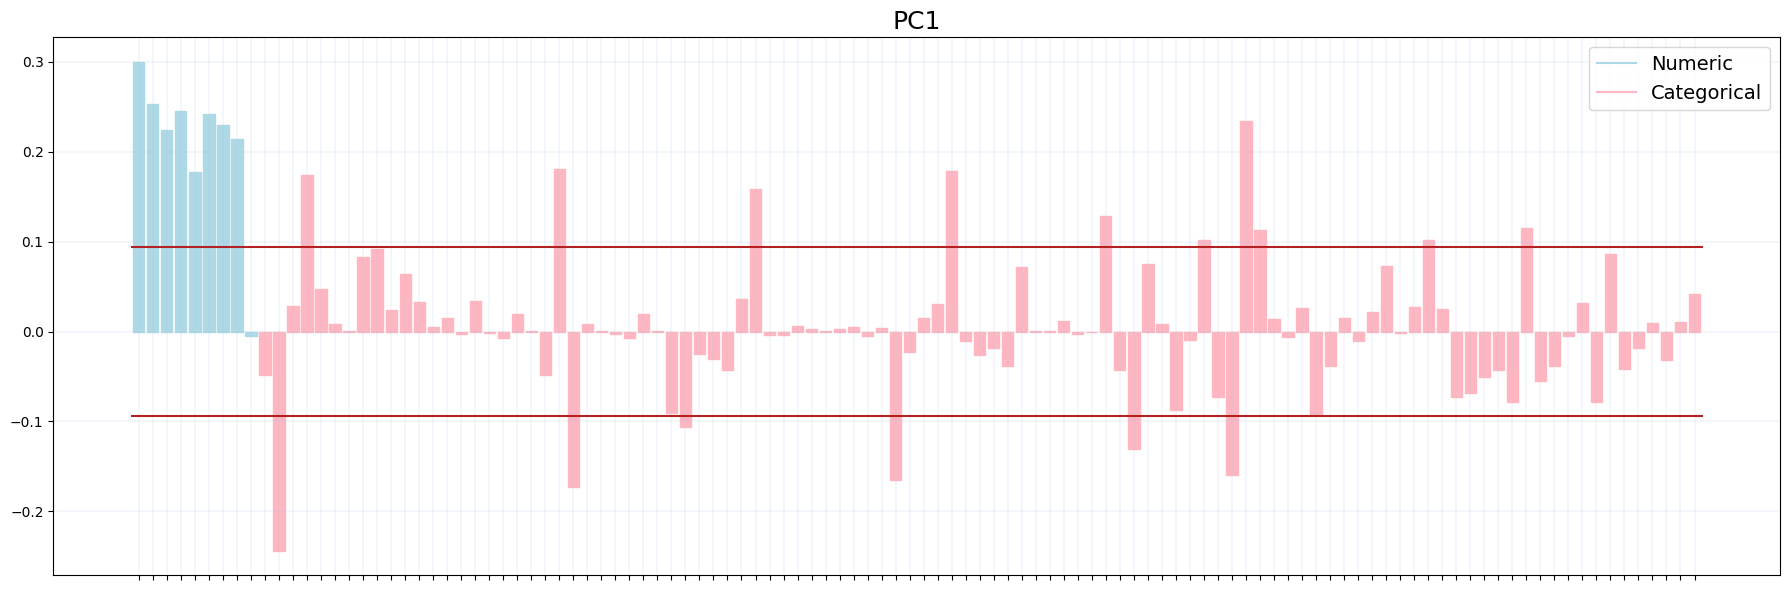


********** PC1 **********
HIGH-VALUED POSITIVE COMPONENTS: ['Displacement (ccm)', 'Power (hp)', 'Torque (Nm)', 'Bore (mm)', 'Stroke (mm)', 'Fuel capacity (lts)', 'Dry weight (kg)', 'Wheelbase (mm)', 'Engine cylinder-V2', 'Engine stroke- four-stroke', 'Gearbox-6-speed', 'Fuel control-Double Overhead Cams/Twin Cam (DOHC)', 'Cooling system-Liquid', 'Transmission type-Shaft drive', 'Fuel system-injection', 'Fuel system-other', 'Rear tire-other', 'Front suspension-other']

HIGH-VALUED NEGATIVE COMPONENTS: ['Engine cylinder-Single cylinder', 'Engine stroke- two-stroke', 'Gearbox-Automatic', 'Fuel control-Unknown', 'Cooling system-Air', 'Fuel system-carburettor']
**************************



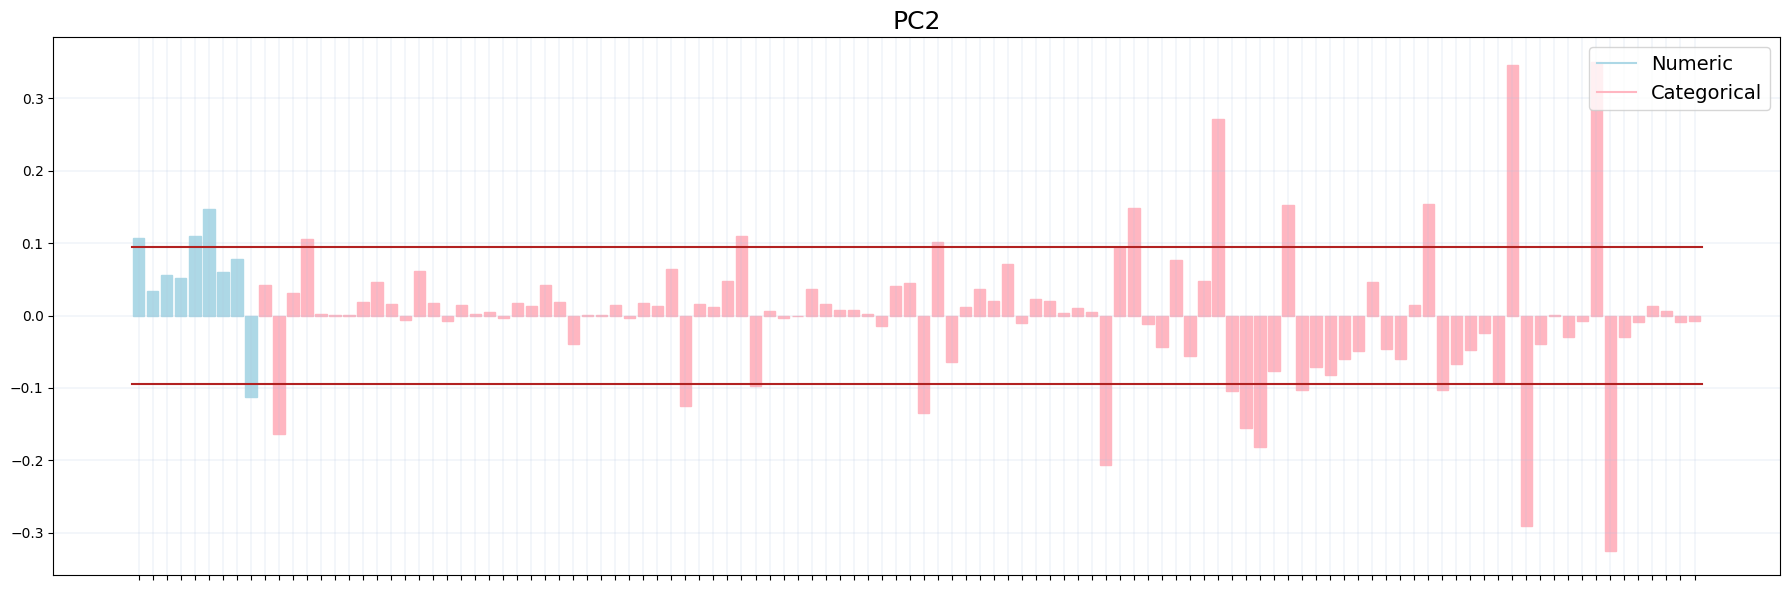


********** PC2 **********
HIGH-VALUED POSITIVE COMPONENTS: ['Displacement (ccm)', 'Stroke (mm)', 'Fuel capacity (lts)', 'Engine cylinder-V2', 'Gearbox-5-speed', 'Fuel control-Overhead Valves (OHV)', 'Cooling system-Air', 'Fuel system-Unknown', 'Front tire-other', 'Rear tire-other', 'Front suspension-Unknown', 'Rear suspension-Unknown']

HIGH-VALUED NEGATIVE COMPONENTS: ['Seat height (mm)', 'Engine cylinder-Single cylinder', 'Gearbox-Automatic', 'Gearbox-6-speed', 'Fuel control-Single Overhead Cams (SOHC)', 'Cooling system-Liquid', 'Fuel system-carburettor', 'Fuel system-injection', 'Fuel system-other', 'Front tire-25/8-12', 'Rear tire-25/10-12', 'Front suspension-other', 'Rear suspension-other']
**************************



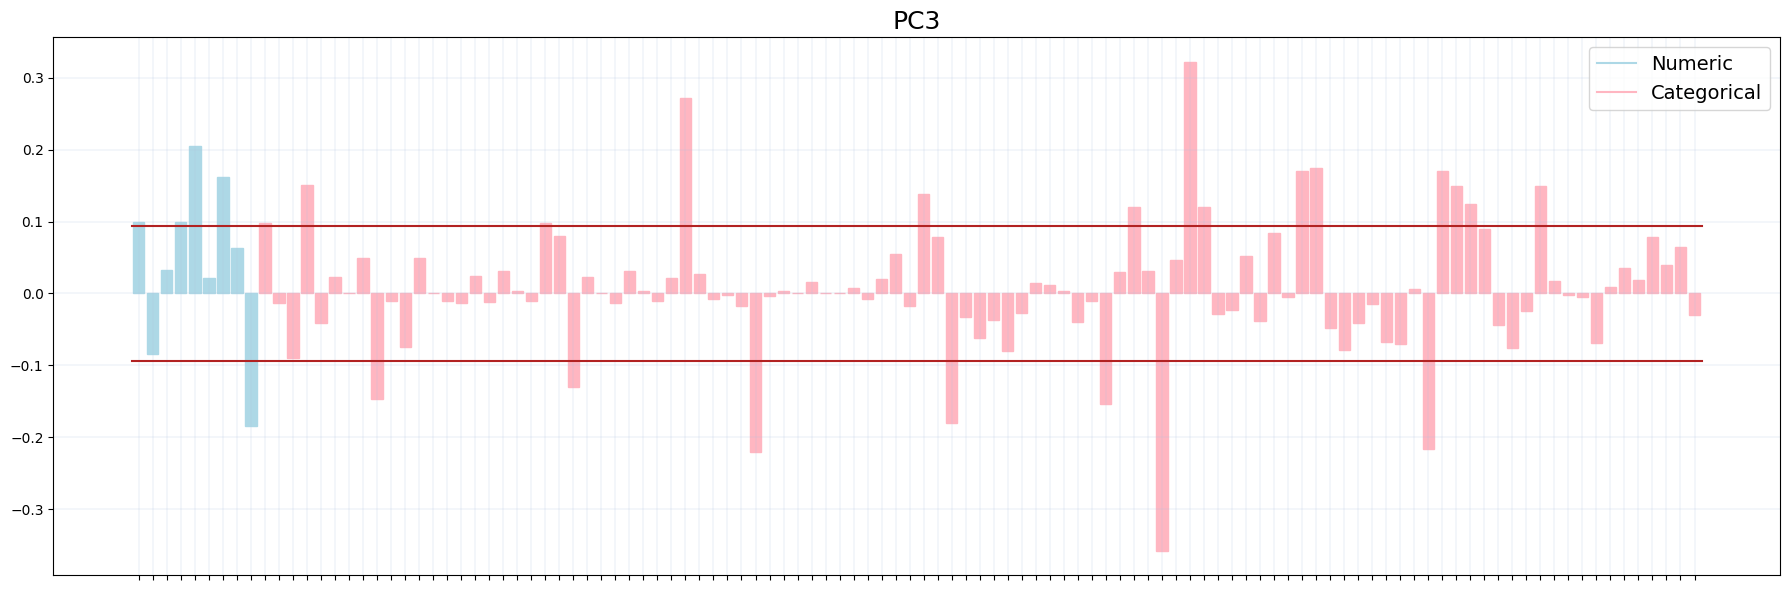


********** PC3 **********
HIGH-VALUED POSITIVE COMPONENTS: ['Displacement (ccm)', 'Bore (mm)', 'Stroke (mm)', 'Dry weight (kg)', 'Engine cylinder-Electric', 'Engine cylinder-V2', 'Engine stroke-Electric', 'Gearbox-Automatic', 'Fuel control-Single Overhead Cams (SOHC)', 'Cooling system-Air', 'Transmission type-Belt', 'Transmission type-Shaft drive', 'Front tire-25/8-12', 'Front tire-120/70-12', 'Rear tire-25/10-12', 'Rear tire-130/70-12', 'Rear tire-120/70-12', 'Front suspension-telescopic fork']

HIGH-VALUED NEGATIVE COMPONENTS: ['Seat height (mm)', 'Engine cylinder-In-line four', 'Engine stroke- two-stroke', 'Gearbox-6-speed', 'Fuel control-Double Overhead Cams/Twin Cam (DOHC)', 'Cooling system-Liquid', 'Transmission type-Chain', 'Rear tire-other']
**************************



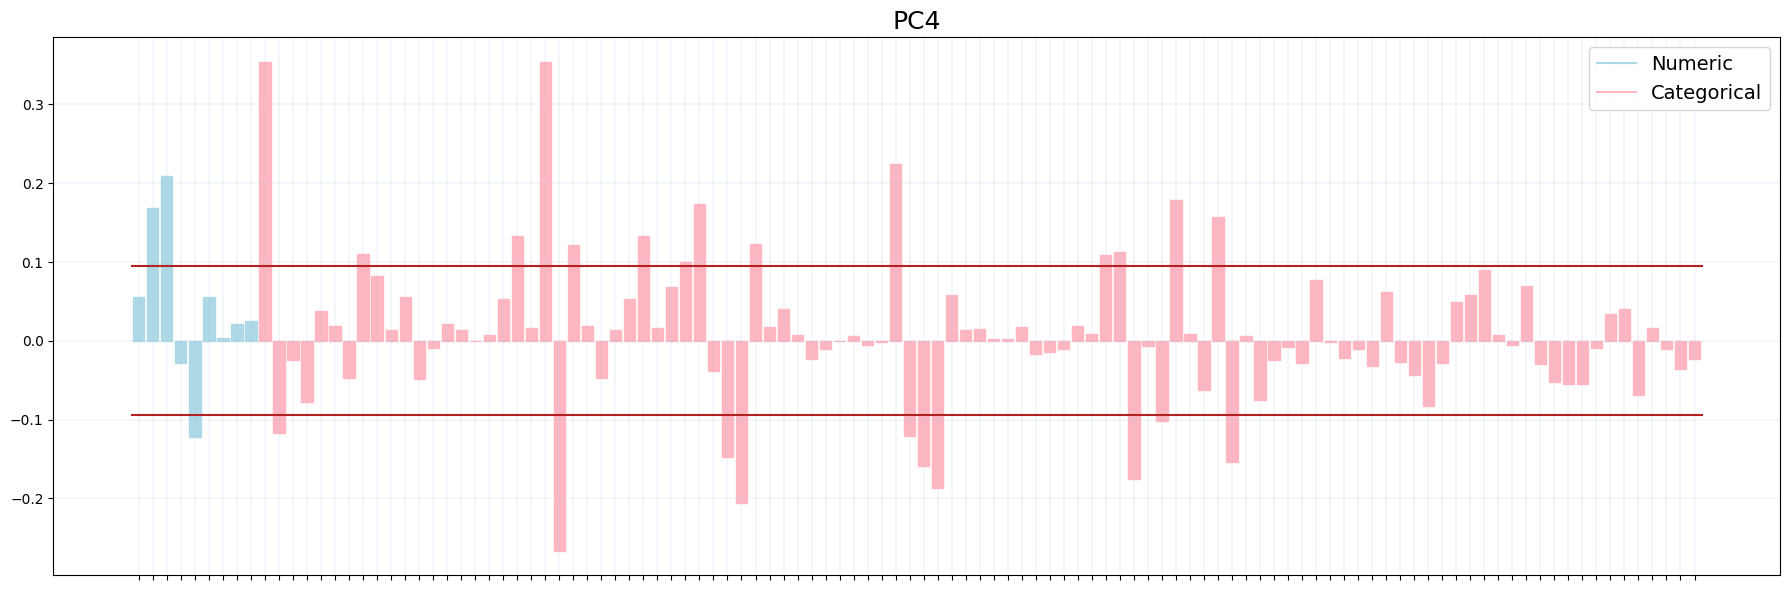


********** PC4 **********
HIGH-VALUED POSITIVE COMPONENTS: ['Power (hp)', 'Torque (Nm)', 'Engine cylinder-Electric', 'Engine cylinder-V8', 'Engine cylinder-Gas turbine', 'Engine stroke-Electric', 'Engine stroke- two-stroke', 'Engine stroke-Gas turbine', 'Gearbox-Automatic', 'Gearbox-1-speed', 'Gearbox-6-speed', 'Fuel control-Unknown', 'Cooling system-Liquid', 'Cooling system-Unknown', 'Transmission type-Unknown', 'Fuel system-Unknown']

HIGH-VALUED NEGATIVE COMPONENTS: ['Stroke (mm)', 'Engine cylinder-Single cylinder', 'Engine stroke- four-stroke', 'Gearbox-4-speed', 'Gearbox-5-speed', 'Fuel control-Overhead Cams (OHC)', 'Fuel control-Single Overhead Cams (SOHC)', 'Fuel control-Overhead Valves (OHV)', 'Cooling system-Air', 'Transmission type-Chain', 'Fuel system-carburettor']
**************************



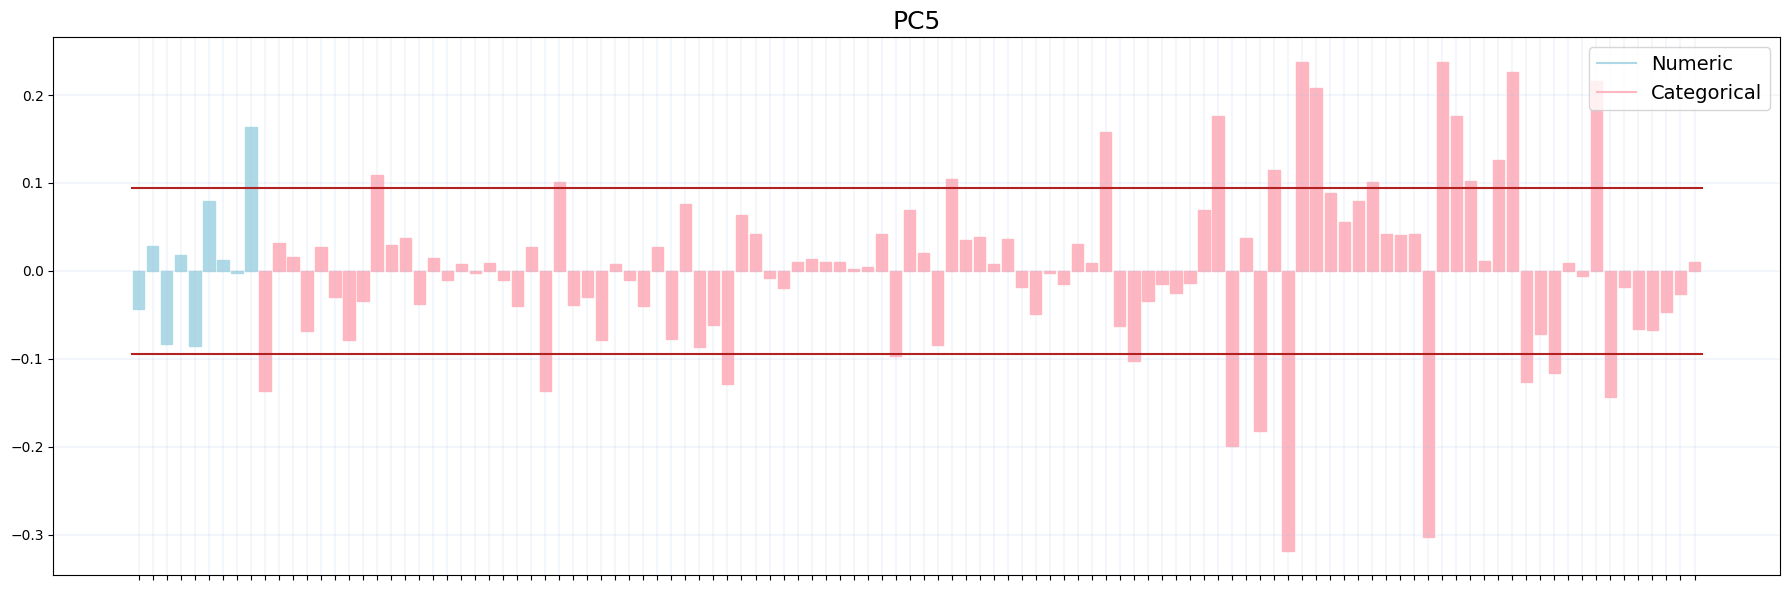


********** PC5 **********
HIGH-VALUED POSITIVE COMPONENTS: ['Seat height (mm)', 'Engine cylinder-In-line four', 'Engine stroke- four-stroke', 'Fuel control-Double Overhead Cams/Twin Cam (DOHC)', 'Cooling system-Liquid', 'Fuel system-Unknown', 'Fuel system-efi', 'Front tire-25/8-12', 'Front tire-120/70-12', 'Front tire-100/90-18', 'Rear tire-25/10-12', 'Rear tire-130/70-12', 'Rear tire-120/70-12', 'Rear tire-130/70-17', 'Front suspension-Unknown', 'Rear suspension-Unknown']

HIGH-VALUED NEGATIVE COMPONENTS: ['Engine cylinder-Electric', 'Engine stroke-Electric', 'Gearbox-4-speed', 'Fuel control-Unknown', 'Cooling system-Air', 'Fuel system-carburettor', 'Fuel system-other', 'Front tire-other', 'Rear tire-other', 'Front suspension-other', 'Front suspension-telescopic', 'Rear suspension-other']
**************************



In [17]:
#PCs Xworkdf_std

col_numeric = Xworkdf_std.columns[:9]

#Defining epsilon
eps = np.sqrt(1 / pca_std.n_features_)

#For-cycle to generalize the plot commands
print("********** Standard Scaled Data **********")
for ii in range(m_std):
    plt.figure(figsize = (18, 6))
    bars = plt.bar(np.arange(pca_std.n_features_), pca_std.components_[ii, :])
    
    #Setting colors: blue bar if it is a numeric feature and red if it is categorical
    for i, bar in enumerate(bars):
        col = Xworkdf_std.columns[i]
        if col in col_numeric:
            bar.set_color('lightblue')
        else:
            bar.set_color('lightpink')
    
    #Making the legend
    plt.legend(handles = [plt.Line2D([0], [0], color = 'lightblue', label = 'Numeric'),
                        plt.Line2D([0], [0], color = 'lightpink', label = 'Categorical')], loc = 'upper right', fontsize = 14)
    
    # --- red line denoting the threshold [-eps, +eps] -----------------
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [eps, eps], 'firebrick')
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [-eps, -eps], 'firebrick')
    # ------------------------------------------------------------------
    plt.xticks(ticks = np.arange(pca_std.n_features_), labels = [], rotation = 75)
    plt.title(f'PC{ii + 1}', fontsize = 18)
    plt.rc('xtick', labelsize = 20)
    plt.grid(color = 'lightsteelblue', linestyle = '-', linewidth = 0.2)
    plt.tight_layout()
    plt.show()
    
    #Selecting features with contribute greater than the threshold
    ind_great_pos_PCii = np.argwhere(pca_std.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_std.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [Xworkdf_std.columns[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [Xworkdf_std.columns[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'********** PC{ii+1} **********')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('**************************')
    print('')

Looking at the barplots and the features printed above:

PC1: "Power and Performance" <br>
'Displacement (ccm)', 'Power (hp)', 'Torque (Nm)', 'Fuel capacity (lts)', 'Fuel system-injection', 'Engine cylinder-V2' contribute positively to the first PC, so increasing one of these increases also the 1PC, generally speaking increasing these attributes (or having the presence of the categorical attributes) gives the motorcycle more power and better performance. <br>
On the other hand, 'Engine cylinder-Single cylinder' contributes negatively, single cylinder engines are mostly used in relatively lower displacement motorcycles whereas twin cylinders are used in bigger displacement engines and so it seems to represent less power.

PC2: Air (+) Vs Liquid (-) <br>
'Front suspension-Unknown', 'Rear suspension-Unknown', 'Fuel system-Unknown' are in the higher-valued positive components, but they  represent missing information. <br>
While "Front suspension-other" e "Rear suspension-other" contribute negatively but they represent other levels of the categories without a name. <br>
Moreover it could be seen that also 'Cooling system-Air' is in the higher-value positive components while 'Cooling system-Liquid' is in the higher-valued negative components. <br>
Air cooling systems are less efficient during long rides and in hot conditions and have less control over the temperature of the motorcycle, leading to a possible overheating. <br>
Liquid system has the ability to control the operating temperature.

PC3: Comfort (+) Vs Less comfort-oriented (-) <br>
'Gearbox-Automatic', 'Transmission type-Belt' are in the higher-values positive components. <br>
While 'Gearbox-6-speed', 'Transmission type-Chain' are in the higher-values negative components. <br>
Motorcycle with Automatic gearbox and Belt transmission give more comfort to
the driver because they do not require manual gear shifting and Belt transmissions are often considered quieter and require less maintenance, while motorcycle with 6-speed gearbox and chain transmission are less comfort oriented because of they require more active engagement from the rider.

PC4: Electric (+) Vs Four-strokes (-) <br>
'Engine cylinder-Electric', 'Engine stroke-Electric' are in the higher-valued positive components, while 'Engine stroke- four-stroke' is the most relevant negative component.

PC5: Not clearly defined (+) Carburettor (-) <br>
'Front tire-25/8-12', 'Front tire-120/70-12', 'Rear tire-25/10-12', 'Front suspension-Unknown', 'Rear suspension-Unknown' are in the higher-value positive componentes but they are too generic or represent missing information to identify a main characteristic. <br>
While 'Fuel system-carburettor' is in the higher-value negative components.

In [18]:
#List of the names assigned to the three PCs of workdf_std
pc_names_std = ["Power and Performance",
                "Air (+) Vs Liquid (-)",
                "Comfort (+) Vs Less comfort-oriented (-)", 
                "Electric (+) Vs Four-strokes (-)",
                "Not clearly defined (+) Carburettor (-)"]

Score graphs with respect to the first $l$ PCs, where $l = 2$ if $m = 2$ and $l = 3$ if $m \geq 3$.

So, l_std = 3 and also l_mm = 3.

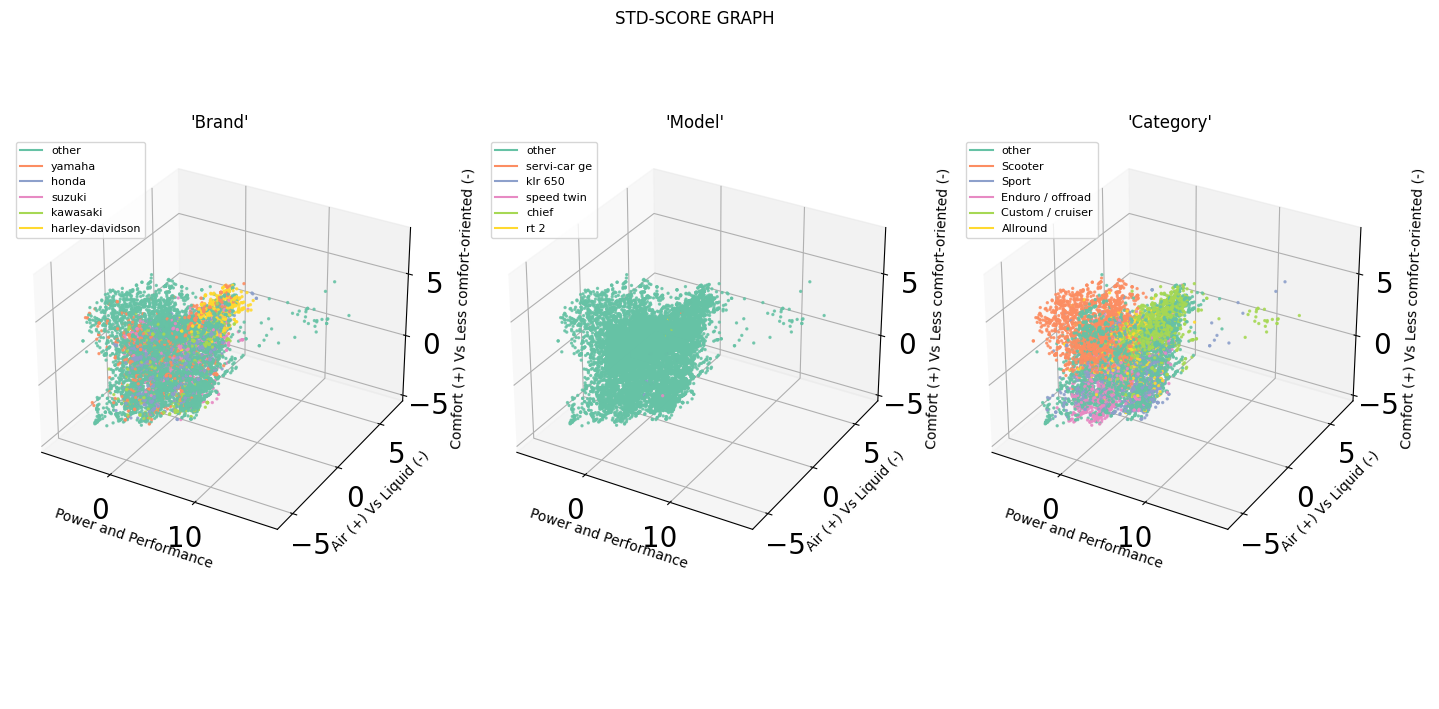

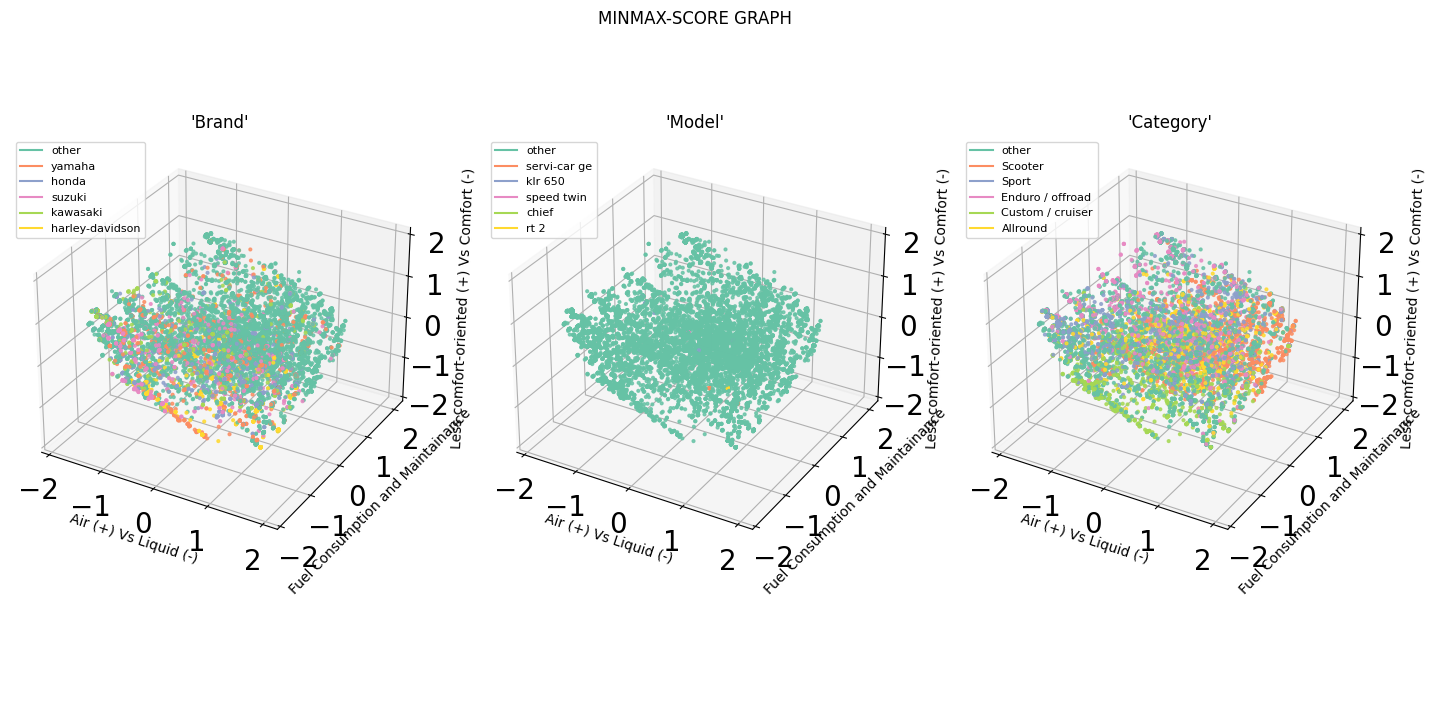

In [19]:
#Score graphs colored by labels

colorset = cm.Set2.colors #Saving the colors of Set2 as a list of 3-tuples

n_level = 5 #Number of levels of each label to show 

#Computing the data transformation into the PC-space 
Y_std = pca_std.transform(Xworkdf_std) #Transformation Xworkdf_std
Y_mm = pca_mm.transform(Xworkdf_mm) #Transformation Xworkdf_mm

target_labels = ["Brand", "Model", "Category"] #Labels


#Making the 3D score graphs-STD

fig_std, ax_std = plt.subplots(1, 3, figsize = (14, 7), 
                           subplot_kw = dict(projection = '3d'))
fig_std.tight_layout(w_pad = 4)
fig_std.suptitle('STD-SCORE GRAPH')
fig_std.text(1,0, "        ")

for i in range(len(target_labels)): #For-cycle on target labels
    label = target_labels[i] #Current label
    level_frequency = workdf[label].value_counts() #Getting the frequency for each level of the labels
    target_levels = level_frequency.nlargest(n_level).index.tolist() #Getting the first n_level levels
    target_levels.insert(0, "other") #Also insert the level 'other'
    level_colors = {target_levels[j]: colorset[j] for j in range(0, len(target_levels))}
    dots_colors = [level_colors[t] 
                   if t in target_levels 
                   else level_colors["other"] for t in workdf[label].values]
    #Legend
    colors_legend = [Line2D([0], [0], color = level_colors[k]) for k in level_colors.keys()] 
    
    #3D score graph
    ax_std[i].scatter(Y_std[:, 0], Y_std[:, 1], Y_std[:, 2], s = 2, c = dots_colors, alpha = 0.8)
    ax_std[i].set_xlabel(pc_names_std[0])
    ax_std[i].set_ylabel(pc_names_std[1])
    ax_std[i].set_zlabel(pc_names_std[2])
    ax_std[i].legend(colors_legend, [k for k in level_colors.keys()], loc = "upper left", fontsize = 8)
    ax_std[i].set_title("'" + str(label) + "'")
    
fig_mm, ax_mm = plt.subplots(1, 3, figsize = (14, 7), 
                           subplot_kw = dict(projection = '3d'))
fig_mm.tight_layout(w_pad = 4)
fig_mm.suptitle('MINMAX-SCORE GRAPH')
fig_mm.text(1,0, "        ")

#Making the 3D score graphs-MINMAX

for i in range(len(target_labels)):
    label = target_labels[i]
    level_frequency = workdf[label].value_counts()
    target_levels = level_frequency.nlargest(n_level).index.tolist()
    target_levels.insert(0, "other")
    level_colors = {target_levels[j]: colorset[j] for j in range(0, len(target_levels))}
    dots_colors = [level_colors[t] 
                   if t in target_levels 
                   else level_colors["other"] for t in workdf[label].values]
    #legend
    colors_legend = [Line2D([0], [0], color = level_colors[k]) for k in level_colors.keys()] 
    
    #3D score graph
    ax_mm[i].scatter(Y_mm[:, 0], Y_mm[:, 1], Y_mm[:, 2], s = 4, c = dots_colors, alpha = 0.8)
    ax_mm[i].set_xlabel(pc_names_mm[0])
    ax_mm[i].set_ylabel(pc_names_mm[1])
    ax_mm[i].set_zlabel(pc_names_mm[2])
    ax_mm[i].legend(colors_legend, [k for k in level_colors.keys()], loc = "upper left", fontsize = 8)
    ax_mm[i].set_title("'" + str(label) + "'", )

Score graphs, coloring the dots with respect to the labels "Brand", "Model" and "Category". The label "Year" has not been considered, and also the label "Rating" (because it is too sparse).

Both in the score graph (Std) and the score graph (MinMax) colored by Model the dominant is the level "Other" due to very few records per Model. 
In the graphs colored by Brand, dots are not partitioned very well because all the brands make different types of motrcycle with various characteristics.
While in the graphs colored by Category (especially in the score graph-std), category are better partitioned, such as the Category Scooter seems to have higher values in the z-axis (reasonable with an association with more comfort using a scooter, it is likely to be automatic).

## Exercise 5 (k-Means)

Running the k-Means algorithm on Xworkdf_std e Xworkdf_mm with respect to the PC-space to indentify the best number of clusters k using the silhouette coefficient.

In [20]:
print("********** Running k-means on Y_std **********")

#Initializing some lists to store the temporary results 
km_list_std = [] #List of k-means iterations
silcoeff_list_std = [] #List of silhouette coefficient
k_list_std = list(range(3, 11)) #List of number k

#For-cycle to run the k-means and measuring the silhouette coefficient
for i in range(len(k_list_std)):
    km_list_std.append(KMeans(n_clusters = k_list_std[i], n_init = 3, random_state = rs))
    km_std = km_list_std[i] #K-Means object
    km_std.fit(Y_std) #Fitting
    silcoeff_list_std.append(silhouette_score(Y_std, km_std.labels_)) #Computing the coefficient
    
#Finding the best value of k and the bet KMeans object
i_best_std = np.argmax(silcoeff_list_std) #Index of the best coefficient
k_std = k_list_std[i_best_std] #Number k with the best coefficient
km_std = km_list_std[i_best_std] #KMeans object of the best coefficient
sil_coeff_std = np.max(silcoeff_list_std) #Best silhouette coefficient
# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH: ******************')
print(f'BEST SILHOUETTE SCORE: {sil_coeff_std} --> k = {k_std}')
print('**************************************************************')

********** Running k-means on Y_std **********


****************** RESULTS OF THE SEARCH: ******************
BEST SILHOUETTE SCORE: 0.3082631969067247 --> k = 6
**************************************************************


In [21]:
#Using a gridsearch to vary the number of clusters and n_init

silcoeff_list_std = []

param_grid = {
    'n_init': list(range(3, 25, 7)),
    'algorithm': ['full', 'elkan', 'auto']
}

for config in ParameterGrid(param_grid):
    km_std = KMeans(**config, random_state = rs, n_clusters = 6)
    km_std.fit(Y_std)
    silcoeff_list_std.append(silhouette_score(Y_std, km_std.labels_))

print("********** Results of the gridsearch **********")

for sil, param in zip(silcoeff_list_std, list(ParameterGrid(param_grid))):
    print("The silhouette is:" + str(sil) + " with configuration:" + str(param))

********** Results of the gridsearch **********
The silhouette is:0.3082631969067247 with configuration:{'algorithm': 'full', 'n_init': 3}
The silhouette is:0.30825620272909665 with configuration:{'algorithm': 'full', 'n_init': 10}
The silhouette is:0.30825620272909665 with configuration:{'algorithm': 'full', 'n_init': 17}
The silhouette is:0.30823870125025227 with configuration:{'algorithm': 'full', 'n_init': 24}
The silhouette is:0.3082631969067247 with configuration:{'algorithm': 'elkan', 'n_init': 3}
The silhouette is:0.30825620272909665 with configuration:{'algorithm': 'elkan', 'n_init': 10}
The silhouette is:0.30825620272909665 with configuration:{'algorithm': 'elkan', 'n_init': 17}
The silhouette is:0.30823870125025227 with configuration:{'algorithm': 'elkan', 'n_init': 24}
The silhouette is:0.3082631969067247 with configuration:{'algorithm': 'auto', 'n_init': 3}
The silhouette is:0.30825620272909665 with configuration:{'algorithm': 'auto', 'n_init': 10}
The silhouette is:0.3082

In [22]:
print("********** Running k-means on Y_mm **********")

#Initializing some lists to store the temporary results 
km_list_mm = [] #List of k-means iterations
silcoeff_list_mm = [] #List of silhouette coefficient
k_list_mm = list(range(3, 11)) #List of number k

#For-cycle to run the k-means and measuring the silhouette coefficient
for i in range(len(k_list_mm)):
    km_list_mm.append(KMeans(n_clusters = k_list_mm[i], n_init = 3, random_state = rs))
    km_mm = km_list_mm[i] #K-Means object
    km_mm.fit(Y_mm) #Fitting
    silcoeff_list_mm.append(silhouette_score(Y_mm, km_mm.labels_)) #Computing the coefficient
    
#Finding the best value of k and the bet KMeans object
i_best_mm = np.argmax(silcoeff_list_mm) #Index of the best coefficient
k_mm = k_list_mm[i_best_mm] #Number k with the best coefficient
km_mm = km_list_mm[i_best_mm] #KMeans object of the best coefficient
sil_coeff_mm = np.max(silcoeff_list_mm) #Best silhouette coefficient
# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH: ******************')
print(f'BEST SILHOUETTE SCORE: {sil_coeff_mm} --> k = {k_mm}')
print('**************************************************************')

********** Running k-means on Y_mm **********


****************** RESULTS OF THE SEARCH: ******************
BEST SILHOUETTE SCORE: 0.37150867147678857 --> k = 3
**************************************************************


In [23]:
#Using a gridsearch to vary the number of clusters and n_init

silcoeff_list_mm = []

param_grid = {
    'n_init': list(range(3, 25, 7)),
    'algorithm': ['full', 'elkan', 'auto']
}

for config in ParameterGrid(param_grid):
    km_mm = KMeans(**config, random_state = rs, n_clusters = 3)
    km_mm.fit(Y_mm)
    silcoeff_list_mm.append(silhouette_score(Y_mm, km_mm.labels_))

print("********** Results of the gridsearch **********")

for sil, param in zip(silcoeff_list_mm, list(ParameterGrid(param_grid))):
    print("The silhouette is:" + str(sil) + " with configuration:" + str(param))

********** Results of the gridsearch **********
The silhouette is:0.37150867147678857 with configuration:{'algorithm': 'full', 'n_init': 3}
The silhouette is:0.3715052408297246 with configuration:{'algorithm': 'full', 'n_init': 10}
The silhouette is:0.3715052408297246 with configuration:{'algorithm': 'full', 'n_init': 17}
The silhouette is:0.3715052408297246 with configuration:{'algorithm': 'full', 'n_init': 24}
The silhouette is:0.37150867147678857 with configuration:{'algorithm': 'elkan', 'n_init': 3}
The silhouette is:0.3715052408297246 with configuration:{'algorithm': 'elkan', 'n_init': 10}
The silhouette is:0.3715052408297246 with configuration:{'algorithm': 'elkan', 'n_init': 17}
The silhouette is:0.3715052408297246 with configuration:{'algorithm': 'elkan', 'n_init': 24}
The silhouette is:0.37150867147678857 with configuration:{'algorithm': 'auto', 'n_init': 3}
The silhouette is:0.3715052408297246 with configuration:{'algorithm': 'auto', 'n_init': 10}
The silhouette is:0.37150524

Using a gridsearch to vary 'n_init' and 'algorithm' there are no clear differences.

## Exercise 6 (Clusters and Centroid Interpretation and Visualization)

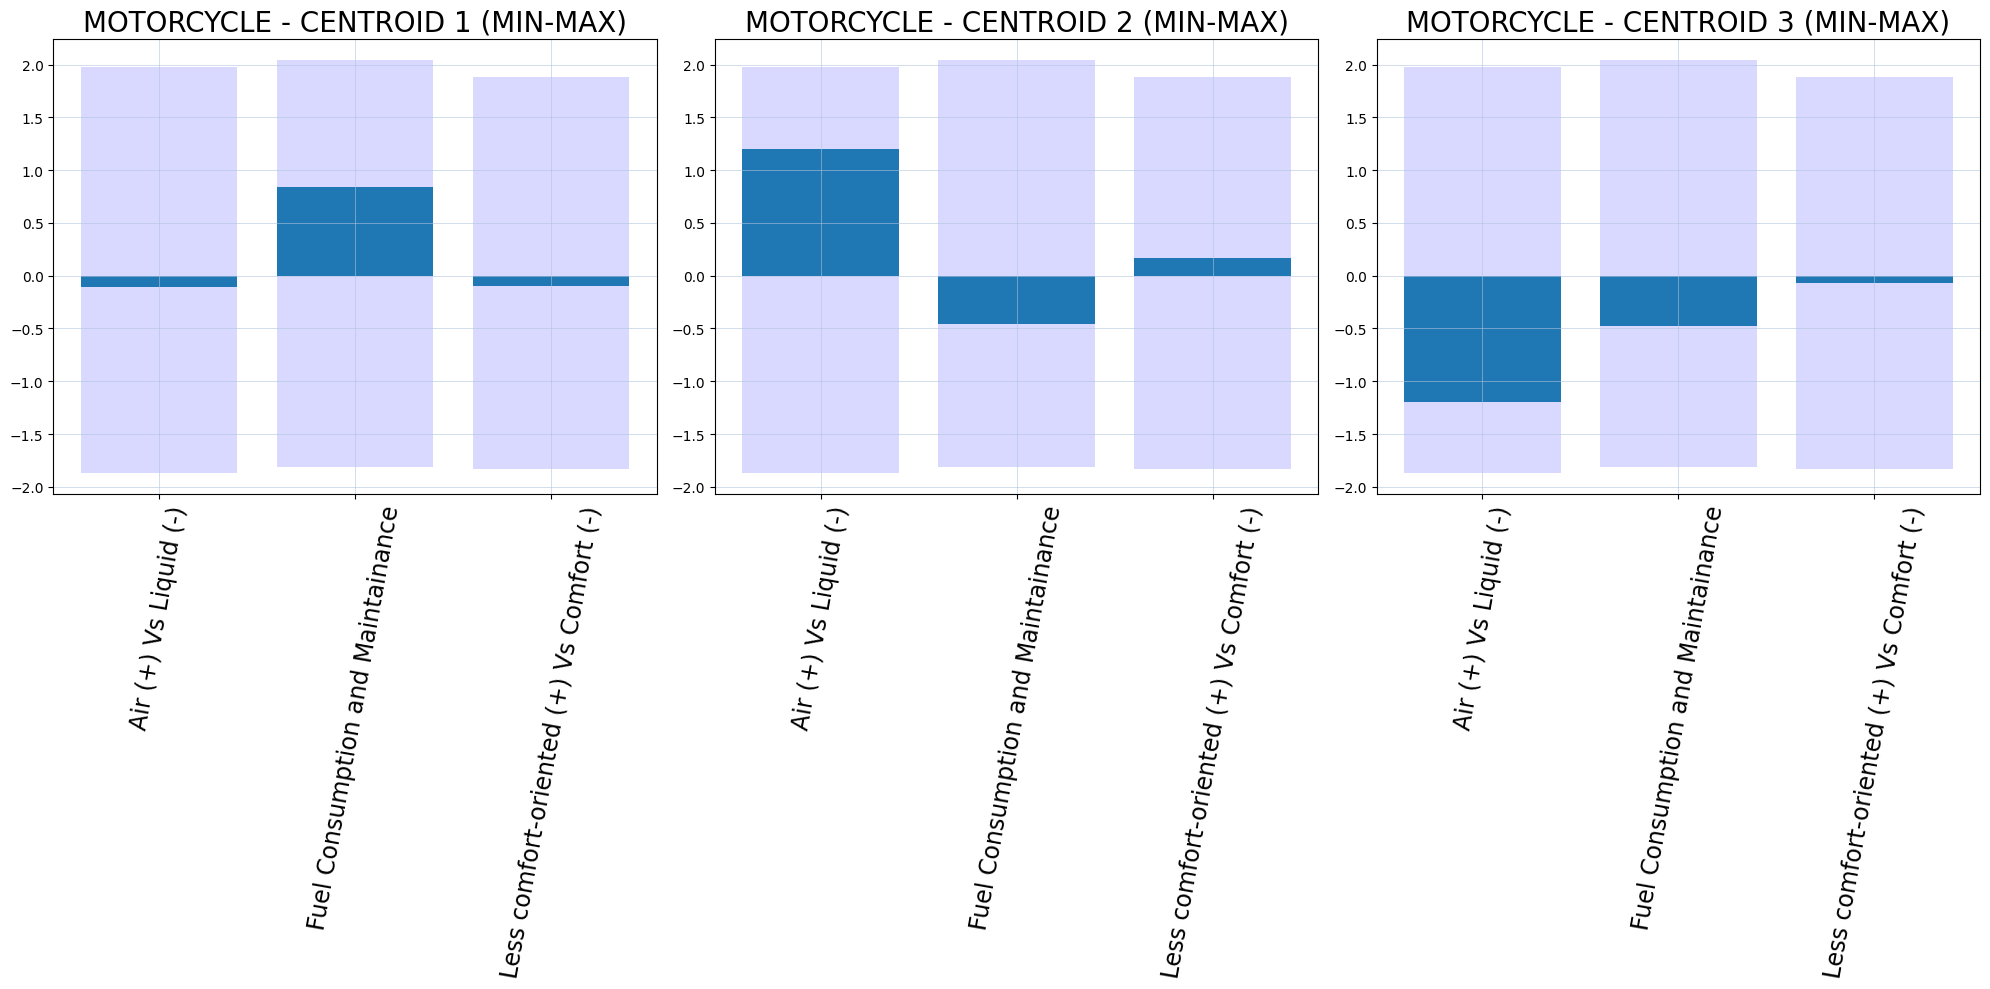

In [24]:
# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE (MIN-MAX)
maxs_y_mm = Y_mm.max(axis = 0) 
mins_y_mm = Y_mm.min(axis = 0) 

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids_mm, ax_centroids_mm = plt.subplots(1, 3, figsize = (20, 10))
for ii in range(k_mm):
    ax_centroids_mm[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), maxs_y_mm, color = 'blue', alpha=0.15)
    ax_centroids_mm[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), mins_y_mm, color = 'blue', alpha=0.15)
    ax_centroids_mm[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), km_mm.cluster_centers_[ii, :])
    ax_centroids_mm[ii].set_xticks(ticks = np.arange(km_mm.cluster_centers_.shape[1]))
    ax_centroids_mm[ii].set_xticklabels(labels = pc_names_mm, rotation = 80, fontsize = 17)
    ax_centroids_mm[ii].grid(color = 'lightsteelblue', linestyle = '-', linewidth = 0.4, which = 'both')
    plt.tight_layout()
    ax_centroids_mm[ii].set_title(f'MOTORCYCLE - CENTROID {ii+1} (MIN-MAX)', fontsize = 20)

Looking at the barplots, we could notice that:

Centroid 1: this centroid represents motorcycles that require frequent maintenance and have high fuel consumption.

Centroid 2 "Air": this centroid represents motorcycle with air-cooling system and which consume less fuel.

Centroid 3 "Liquid": this centroid represents motorcycle with liquid-cooling system and which consume less fuel.

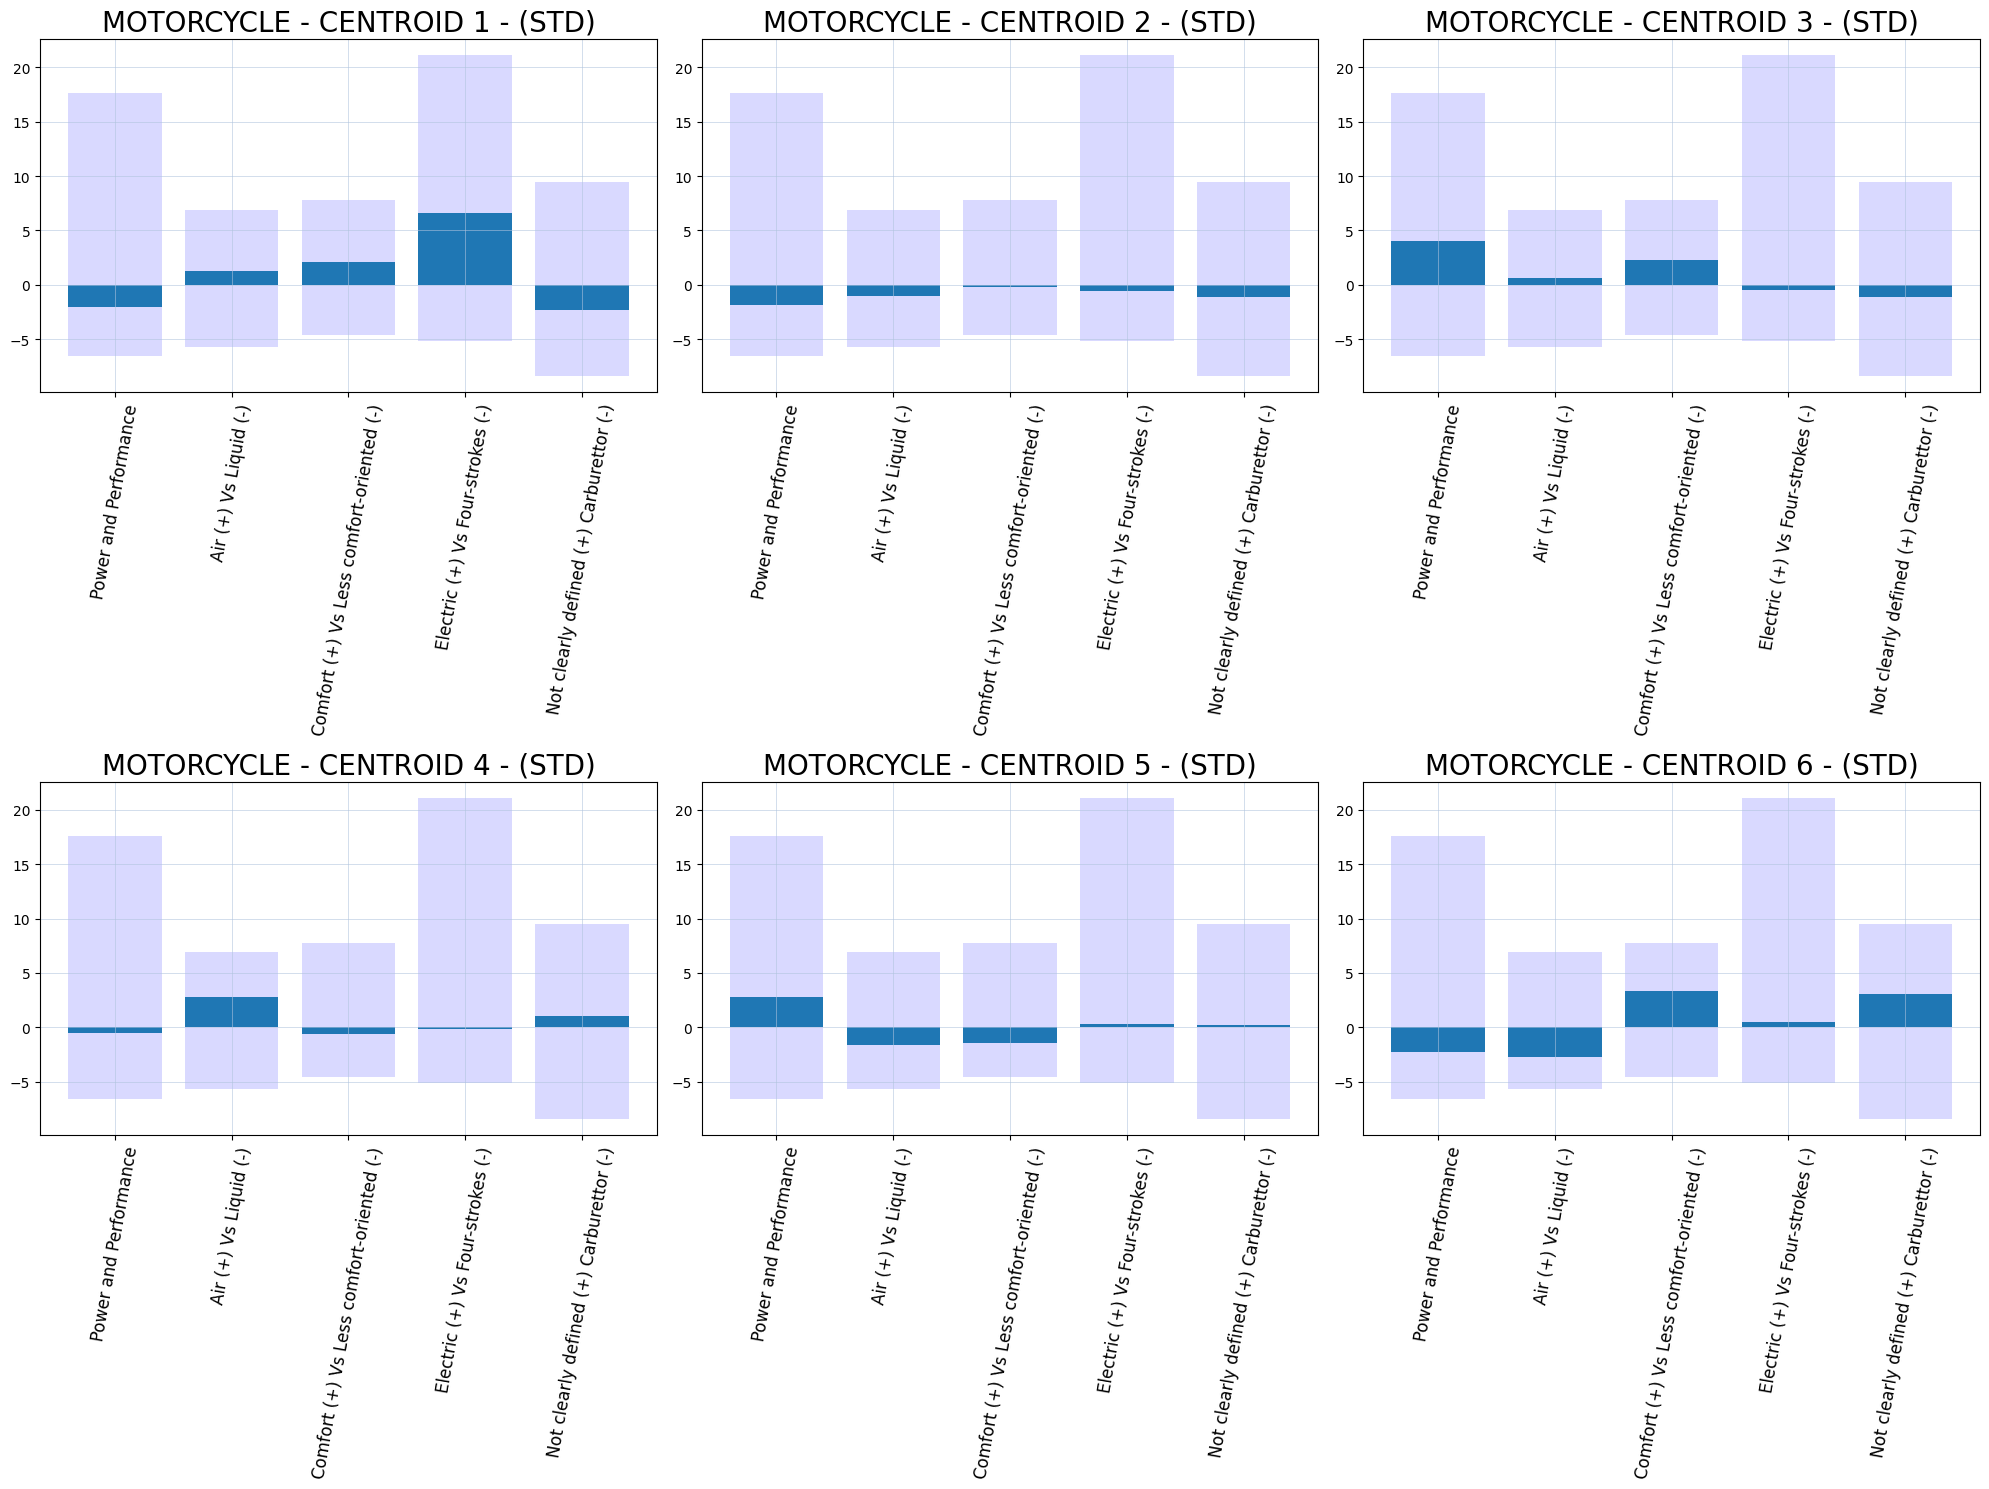

In [25]:
#COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE (STD)
maxs_y_std = Y_std.max(axis = 0) 
mins_y_std = Y_std.min(axis = 0) 

# MAKE THE BARPLOTS OF THE CENTROIDS (STD)
fig_centroids_std, ax_centroids_std = plt.subplots(2, 3, figsize = (20, 15))
for ii in range(k_std):
    ir = ii // 3
    ic = ii % 3
    ax_centroids_std[ir, ic].bar(np.arange(km_std.cluster_centers_.shape[1]), maxs_y_std, color = 'blue', alpha=0.15)
    ax_centroids_std[ir, ic].bar(np.arange(km_std.cluster_centers_.shape[1]), mins_y_std, color = 'blue', alpha=0.15)
    ax_centroids_std[ir, ic].bar(np.arange(km_std.cluster_centers_.shape[1]), km_std.cluster_centers_[ii, :])
    ax_centroids_std[ir, ic].set_xticks(ticks = np.arange(km_std.cluster_centers_.shape[1]))
    ax_centroids_std[ir, ic].set_xticklabels(labels = pc_names_std, rotation = 80, fontsize = 12)
    ax_centroids_std[ir, ic].grid(color = 'lightsteelblue', linestyle = '-', linewidth = 0.4, which = 'both')
    plt.tight_layout()
    ax_centroids_std[ir, ic].set_title(f'MOTORCYCLE - CENTROID {ii+1} - (STD)', fontsize = 20)

Looking at the barplots, we could notice that:

Centroid 1 "Electric": this centroid represents electric motorcycle.

Centroid 2 "Not crearly definded": this centroid doesn't contain enough information to identify it.

Centroid 3 "Powerful and Comfort": this centroid could represent powerful motorcycle with high performance but also with a comfortable riding experience.

Centroid 4 "Air": this centroid represents motorcycle with air-cooling system.

Centroid 5 "Not crearly defined".

Centroid 6 "Urban": this centroid seems to represents motorcycle not very efficient (in terms of performance), but it is made for a comfortable riding experience.

Plotting the score graphs with cluster centroids could be useful to visualize them.

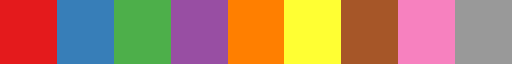

In [26]:
cm.Set1

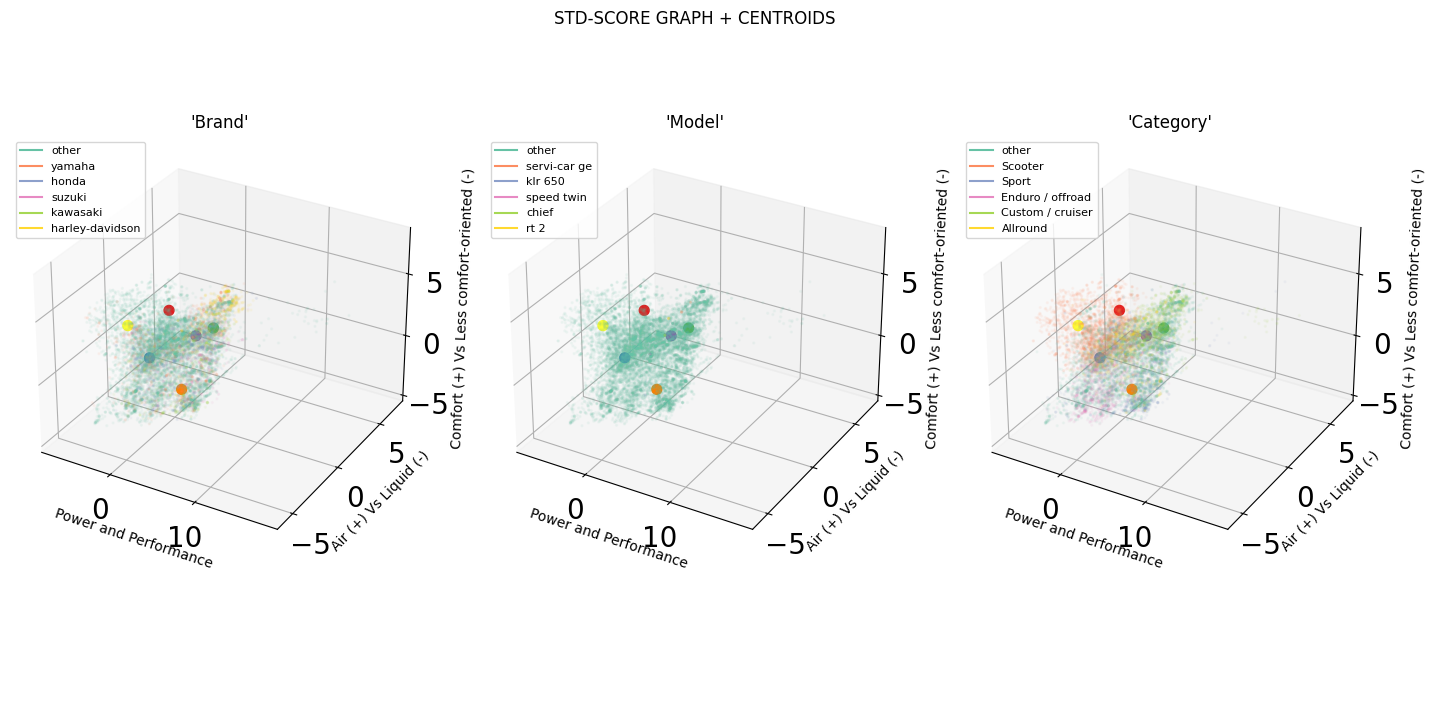

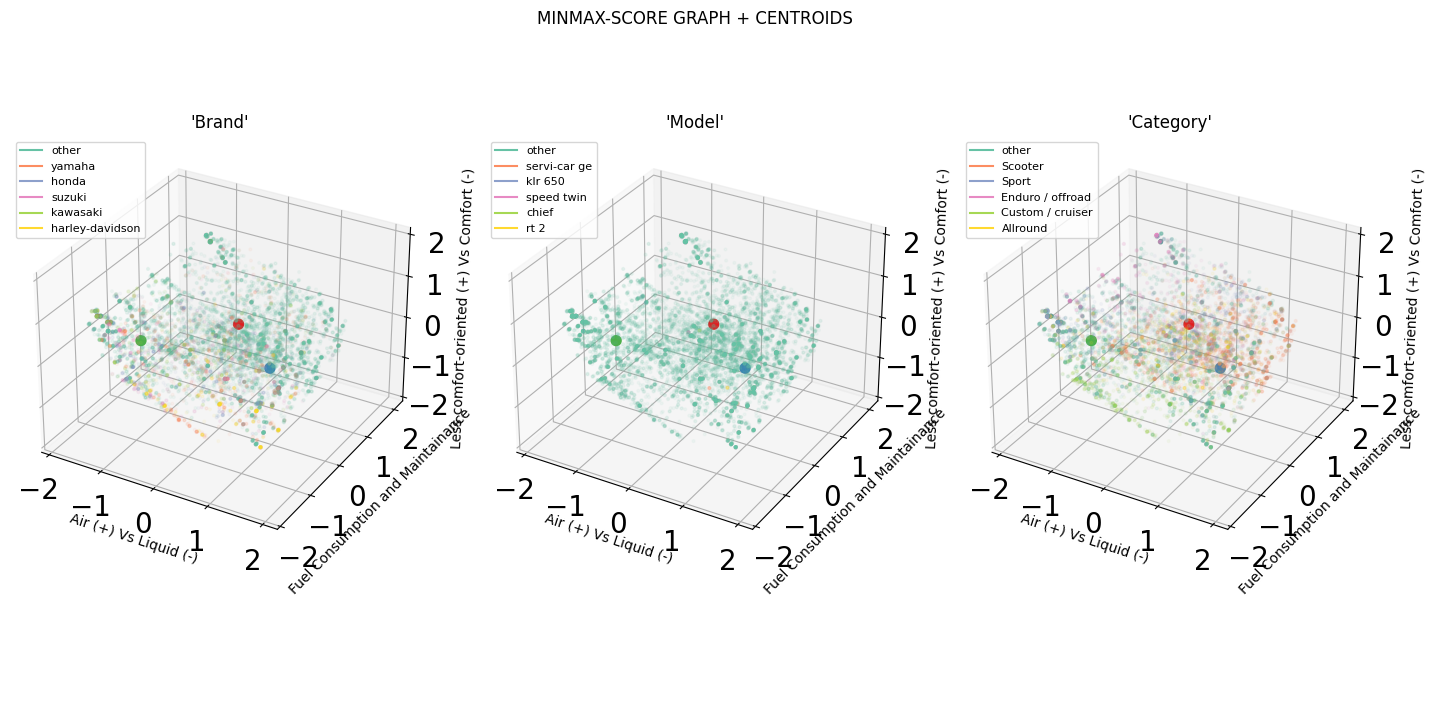

In [27]:
#Score graphs colored by labels

colorset = cm.Set2.colors #Saving the colors of Set2 as a list of 3-tuples

n_level = 5 #Number of levels of each label to show 

#Computing the data transformation into the PC-space 
Y_std = pca_std.transform(Xworkdf_std) #Transformation Xworkdf_std
Y_mm = pca_mm.transform(Xworkdf_mm) #Transformation Xworkdf_mm

target_labels = ["Brand", "Model", "Category"] #Labels


#Making the 3D score graphs-STD

fig_std, ax_std = plt.subplots(1, 3, figsize = (14, 7), 
                           subplot_kw = dict(projection = '3d'))
fig_std.tight_layout(w_pad = 4)
fig_std.suptitle('STD-SCORE GRAPH + CENTROIDS')
fig_std.text(1,0, "        ")

for i in range(len(target_labels)): #For-cycle on target labels
    label = target_labels[i] #Current label
    level_frequency = workdf[label].value_counts() #Getting the frequency for each level of the labels
    target_levels = level_frequency.nlargest(n_level).index.tolist() #Getting the first n_level levels
    target_levels.insert(0, "other") #Also insert the level 'other'
    level_colors = {target_levels[j]: colorset[j] for j in range(0, len(target_levels))}
    dots_colors = [level_colors[t] 
                   if t in target_levels 
                   else level_colors["other"] for t in workdf[label].values]
    #Legend
    colors_legend = [Line2D([0], [0], color = level_colors[k]) for k in level_colors.keys()] 
    
    #3D score graph
    ax_std[i].scatter(Y_std[:, 0], Y_std[:, 1], Y_std[:, 2], s = 2, c = dots_colors, alpha = 0.05)
    ax_std[i].set_xlabel(pc_names_std[0])
    ax_std[i].set_ylabel(pc_names_std[1])
    ax_std[i].set_zlabel(pc_names_std[2])
    ax_std[i].legend(colors_legend, [k for k in level_colors.keys()], loc = "upper left", fontsize = 8)
    ax_std[i].set_title("'" + str(label) + "'")
    
    ax_std[i].scatter(km_std.cluster_centers_[:, 0], km_std.cluster_centers_[:, 1], km_std.cluster_centers_[:, 2], c = cm.Set1.colors[0:6], marker = 'o', linewidths = 5, s = 10, alpha=1.0)
    
fig_mm, ax_mm = plt.subplots(1, 3, figsize = (14, 7), 
                           subplot_kw = dict(projection = '3d'))
fig_mm.tight_layout(w_pad = 4)
fig_mm.suptitle('MINMAX-SCORE GRAPH + CENTROIDS')
fig_mm.text(1,0, "        ")

#Making the 3D score graphs-MINMAX

for i in range(len(target_labels)):
    label = target_labels[i]
    level_frequency = workdf[label].value_counts()
    target_levels = level_frequency.nlargest(n_level).index.tolist()
    target_levels.insert(0, "other")
    level_colors = {target_levels[j]: colorset[j] for j in range(0, len(target_levels))}
    dots_colors = [level_colors[t] 
                   if t in target_levels 
                   else level_colors["other"] for t in workdf[label].values]
    #legend
    colors_legend = [Line2D([0], [0], color = level_colors[k]) for k in level_colors.keys()] 
    
    #3D score graph
    ax_mm[i].scatter(Y_mm[:, 0], Y_mm[:, 1], Y_mm[:, 2], 
               s = 4, c = dots_colors, alpha = 0.05)
    ax_mm[i].set_xlabel(pc_names_mm[0])
    ax_mm[i].set_ylabel(pc_names_mm[1])
    ax_mm[i].set_zlabel(pc_names_mm[2])
    ax_mm[i].legend(colors_legend, [k for k in level_colors.keys()], loc = "upper left", fontsize = 8)
    ax_mm[i].set_title("'" + str(label) + "'", )
    
    ax_mm[i].scatter(km_mm.cluster_centers_[:, 0], km_mm.cluster_centers_[:, 1], km_mm.cluster_centers_[:, 2], c = cm.Set1.colors[0:3], marker = 'o', linewidths = 5, s = 10, alpha=1.0)

## Exercise 7 (Clusters and Centroids Evaluation)

We have done an internal evalution of the cluster with the silhouette scores, in particular, here the results obtained before: <br>
MIN-MAX: SILHOUETTE SCORE: 0.37150867147678857 <br>
STD: SILHOUETTE SCORE: 0.3082631969067247 <br> 
We know that 1 is the best value and the worst value is -1. Values near 0 indicate overlapping clusters. In our case the results obtainded with MIN-MAX scaler are slightly better.

In addition, it could be performed also an external evaluation by analyzing the distribution of the labels inside each cluster. For what we have previous done, the only label which seems to separate better the data was 'Category'. Before the cluster evaluation, 
we check how it is istributed into the dataset.

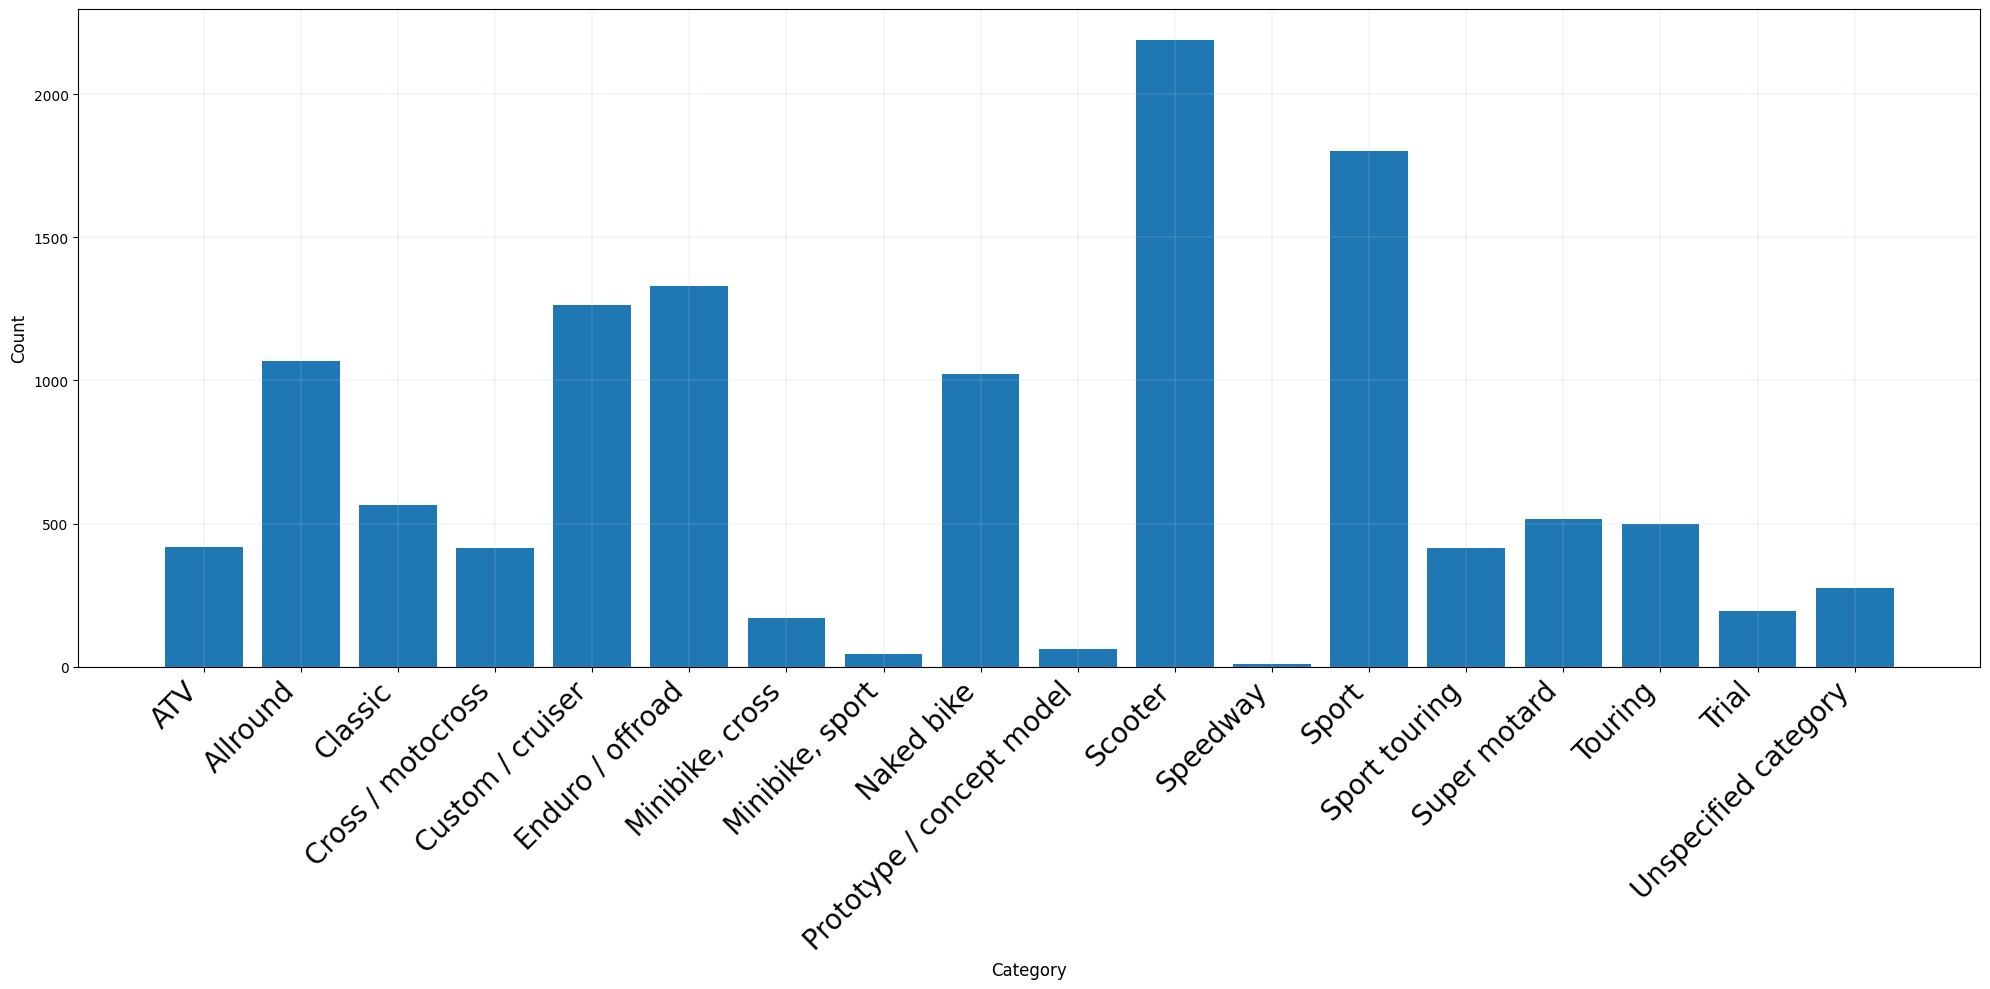

In [28]:
class_, counts_ = np.unique(np.array(workdf['Category']), return_counts = True)
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
plt.bar(class_, counts_)
ax.set_ylabel("Count", fontsize = 12)
ax.set_xlabel("Category", fontsize = 12)
ax.set_xticks(class_)  
ax.set_xticklabels(class_, rotation = 45, ha="right")  
plt.grid(color = 'lightsteelblue', linestyle = '-', linewidth = 0.2)
plt.tight_layout() 
plt.show()

Looking at the barplot we could see that our dataset is not well-balanced, categories such as Minibike/sport, Speedway, Prototype/concept model contain very few records, while Scooter or Sport have more than 1500 records.

In [29]:
#MIN-MAX

clusters = [] #List with cluster names
for i in range(k_mm):
    clusters.append(f'Cluster {i}')

    
Data_cluster_mm = pd.DataFrame(columns = clusters) #Datafram with columns = cluster names

for category in workdf['Category'].unique(): #For-cycle category
    index = workdf[workdf['Category'] == category].index  #Index of record with that category
    cluster_series = pd.Series([f'Cluster {i}' for i in km_mm.labels_[index]]) #Series with cluster indeces
    perc = cluster_series.value_counts(normalize = True) #Percentage
    perc.name = category 
    Data_cluster_mm = pd.concat([Data_cluster_mm, perc.to_frame().T])
Data_cluster_mm.fillna(0, inplace = True)
display(Data_cluster_mm)

,Cluster 0,Cluster 1,Cluster 2
Prototype / concept model,0.177419,0.354839,0.467742
ATV,0.474820,0.040767,0.484412
Allround,0.495790,0.325538,0.178672
Scooter,0.595521,0.299360,0.105119
Sport,0.305941,0.328706,0.365353
Naked bike,0.137965,0.276908,0.585127
Custom / cruiser,0.162441,0.377971,0.459588
Cross / motocross,0.491566,0.250602,0.257831
"Minibike, sport",0.500000,0.434783,0.065217
"Minibike, cross",0.748538,0.251462,0.000000


In [30]:
#STD

clusters = [] #List with cluster names
for i in range(k_std):
    clusters.append(f'Cluster {i}')

    
Data_cluster_std = pd.DataFrame(columns = clusters) #Datafram with columns = cluster names

for category in workdf['Category'].unique():
    index = workdf[workdf['Category'] == category].index 
    cluster_series = pd.Series([f'Cluster {i}' for i in km_std.labels_[index]])
    perc = cluster_series.value_counts(normalize = True) #Percentage
    perc.name = category 
    Data_cluster_std = pd.concat([Data_cluster_std, perc.to_frame().T])
Data_cluster_std.fillna(0, inplace = True)
display(Data_cluster_std)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Prototype / concept model,0.209677,0.096774,0.177419,0.177419,0.322581,0.016129
ATV,0.000000,0.330935,0.055156,0.031175,0.187050,0.395683
Allround,0.011225,0.503274,0.038354,0.282507,0.151543,0.013096
Scooter,0.097349,0.475320,0.005484,0.113803,0.030622,0.277422
Sport,0.021655,0.323154,0.021099,0.284287,0.330927,0.018878
Naked bike,0.013699,0.121331,0.099804,0.259295,0.484344,0.021526
Custom / cruiser,0.001585,0.105388,0.548336,0.288431,0.055468,0.000792
Cross / motocross,0.007229,0.522892,0.000000,0.224096,0.245783,0.000000
"Minibike, sport",0.000000,0.891304,0.000000,0.043478,0.000000,0.065217
"Minibike, cross",0.181287,0.742690,0.000000,0.070175,0.000000,0.005848


Categories with very few records such as Minibike/sport, Speedway in the case of STD result to be identified by one cluster among 6. <br>

While considering more frequent categories, we could notice that they are not well separated among clusters, turning out that we have overlapping clusters considering high-frequency categories, this is because also different categories of motorcycle could share some features and characteristic.

## APPENDIX

### Loading and Preparing the Data

In this section of the Appendix there are some useful tables and graphs for better understand the distribution of data.

In [31]:
#Getting the value counts for every non numerical feature column 
print("**********Value counts for the categorical features**********")
categorical_columns = workdf_copy[features].select_dtypes(exclude = ['number']).columns #Only categorical features
for column in categorical_columns:
    print("The column is:", column)
    print(workdf_copy[column].value_counts())
    print()
    

**********Value counts for the categorical features**********
The column is: Engine cylinder
Single cylinder         6672
V2                      2310
Twin                    1045
In-line four             993
Electric                 351
Two cylinder boxer       305
In-line three            272
V4                       148
Six cylinder boxer        39
In-line six               36
V8                        29
Four cylinder boxer       16
Diesel                    11
V6                        11
Square four cylinder      10
Radial                     6
Gas turbine                5
Single disc Wankel         3
Dual disc Wankel           3
V3                         1
Name: Engine cylinder, dtype: int64

The column is: Engine stroke
 four-stroke            9686
 two-stroke             2191
Electric                 351
Diesel                    11
Square four cylinder      10
Radial                     6
Gas turbine                5
Single disc Wankel         3
Dual disc Wankel           3


**********Boxplots numeric features**********


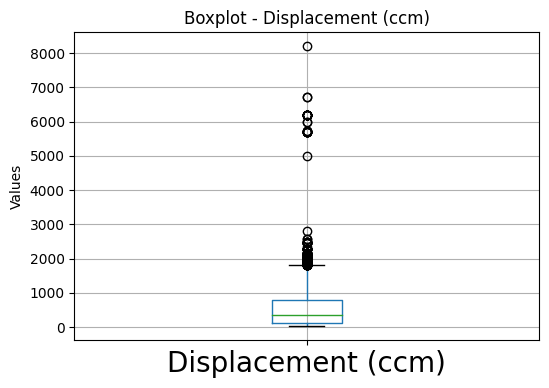

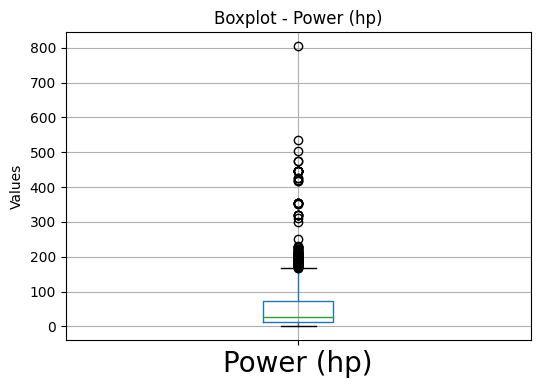

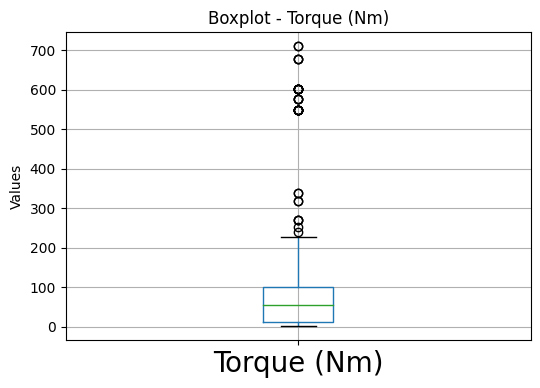

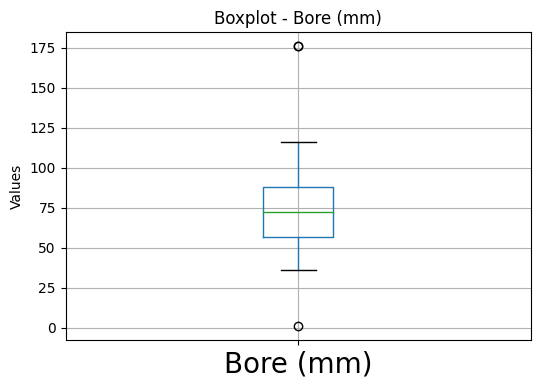

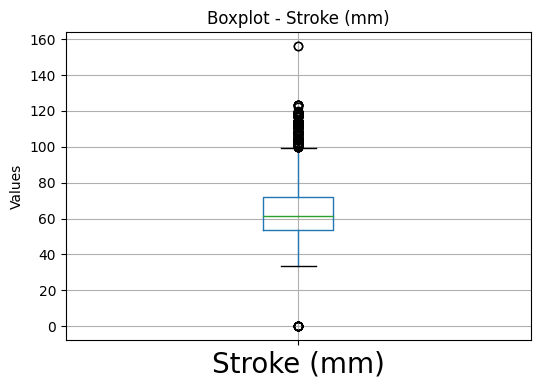

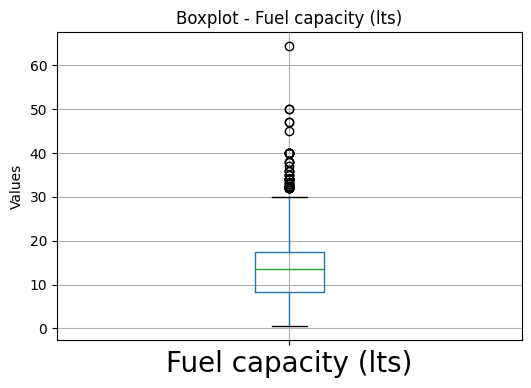

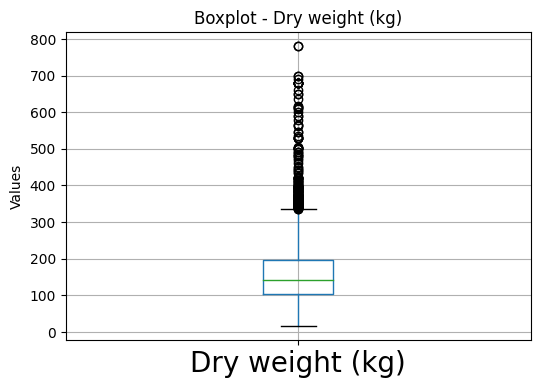

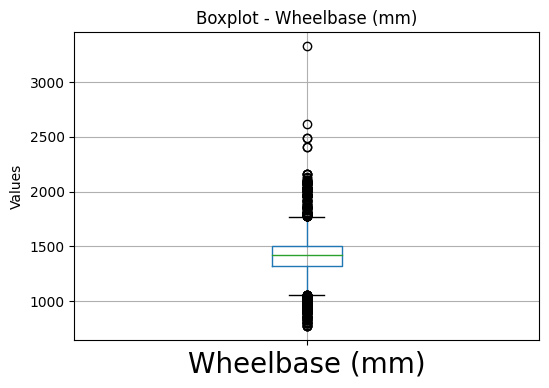

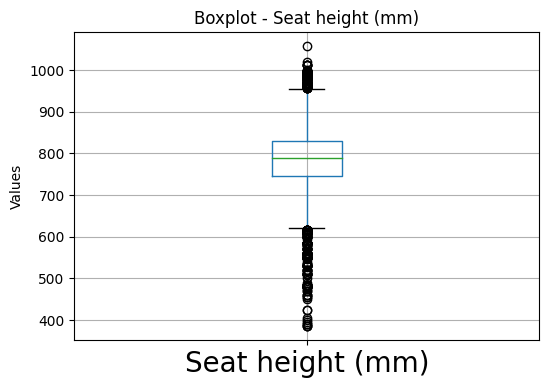

In [32]:
#Boxplot for every numeric features

print("**********Boxplots numeric features**********")
numeric_columns = workdf_copy[features].select_dtypes(include=['number']).columns #Only numeric features
for column in numeric_columns:
    plt.figure(figsize = (6, 4))  
    workdf_copy.boxplot(column = column)
    plt.title(f'Boxplot - {column}')
    plt.ylabel('Values')
    plt.show()